# Natural Language Processing - Bill Text Exploration

**This analysis includes combined text of bill titles and summaries**

Transform the raw data into feature vectors and these new features will be created using the existing dataset. Structure as follows:

Data Exploration
- Word Cloud 

Vectorizers
- Custom and Spacy Tokenizer
- Count Vectors as features
- TF-IDF Vectors as features

- Word level
- N-Gram level

Character level
- Word Embeddings as features
- Text / NLP based features
- Topic Models as features

https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/

In [2]:
import mysql.connector 
import numpy as np
import pandas as pd
import config_final
import requests

import seaborn as sns
sns.set_palette(sns.color_palette("RdYlBu"))

In [3]:
from sodapy import Socrata
import sqlalchemy as db

import config_final as config
from schema import DbSchema



In [4]:
bills_db = DbSchema(config)


In [5]:
def query(q):
    try:
        return pd.read_sql_query(q, engine)
    # Pass when no data is returned    
    except ResourceClosedError:
        pass

def query_list(col, table, distinct = True):
    elts = ['SELECT',
            'DISTINCT' if distinct else '',
            col,
            'FROM',
            table]
    query_str = ' '.join(elts)
    df = query(query_str)
    l = df.iloc[:,0].tolist()
    return l

In [6]:
engine = db.create_engine(f'mysql+mysqlconnector://{config_final.user}:{config_final.password}@{config_final.host}/con_bills')

connection = engine.connect()
metadata=db.MetaData()

In [7]:
df = query('SELECT * FROM con_bills.current_bills WHERE Cong >= 110')


In [8]:
df.shape

(51067, 29)

In [9]:
df.tail()

,BillID,BillType,Chamber,Cong,Cosponsr,IntrDate,Mult,PLaw,Title,Veto,...,PassH,PassS,PLawDate,PLawNum,ImpBill,Majority,Major,Minor,URL,Summary
51062,114-S-995,s,1,114,1.0,2015-04-16 00:00:00,0,0,A bill to establish congressional trade negoti...,0,...,0,0,None,0,1,1,18.0,1802.0,https://www.congress.gov/bill/114th-congress/s...,Bipartisan Congressional Trade Priorities and ...
51063,114-S-996,s,1,114,7.0,2015-04-16 00:00:00,0,0,A bill to facilitate nationwide availability o...,0,...,0,0,None,0,1,0,13.0,1302.0,https://www.congress.gov/bill/114th-congress/s...,Volunteer Income Tax Assistance (VITA) Act
51064,114-S-997,s,1,114,1.0,2015-04-16 00:00:00,0,0,A bill to extend the authorization for the maj...,0,...,0,0,None,0,1,1,3.0,322.0,https://www.congress.gov/bill/114th-congress/s...,"Department of Veterans Affairs Construction, A..."
51065,114-S-998,s,1,114,4.0,2015-04-16 00:00:00,0,0,A bill to establish a process for the consider...,0,...,0,0,None,0,1,1,18.0,1807.0,https://www.congress.gov/bill/114th-congress/s...,American Manufacturing Competitiveness Act of ...
51066,114-S-999,s,1,114,0.0,2015-04-16 00:00:00,0,0,A bill to amend the Small Business Act to prov...,0,...,0,0,None,0,1,1,15.0,1521.0,https://www.congress.gov/bill/114th-congress/s...,Small Business Development Centers Improvement...


**Final Cleaning:**

In [10]:
df['Summary'].isnull().sum()

50

In [11]:
df['Summary'].fillna('None', inplace = True)

In [12]:
df['Summary'].isnull().sum()

0

In [13]:
df['PassH'].value_counts()

0    47042
1     4025
Name: PassH, dtype: int64

In [14]:
# blanks = []

# for i, billID, title, summary, PassH, Cong in df.itertuples():  # iterate over the DataFrame
#     if type(summary)==str:            # avoid NaN values
#         if summary.isspace():         # test 'plot' for whitespace
#             blanks.append(i)
                  
# len(blanks)

In [15]:
df.shape

(51067, 29)

**Combine Title and Summary columns:**

In [16]:
df['combined_text'] = df[['Title', 'Summary']].astype(str).apply(' '.join, axis=1)

In [17]:
# df_combined_text = df['combined_text', 'PassH']

In [18]:
df.isnull().sum()

BillID               0
BillType             0
Chamber              0
Cong                 0
Cosponsr             0
IntrDate            42
Mult                 0
PLaw                 0
Title                0
Veto                 0
Class                0
District             0
FrstConH             0
FrstConS             0
Gender               0
MRef                 0
NameFull             0
Party                0
Postal               0
PassH                0
PassS                0
PLawDate         49674
PLawNum              0
ImpBill              0
Majority             0
Major                0
Minor                0
URL                  0
Summary              0
combined_text        0
dtype: int64

In [19]:
df.head()

,BillID,BillType,Chamber,Cong,Cosponsr,IntrDate,Mult,PLaw,Title,Veto,...,PassS,PLawDate,PLawNum,ImpBill,Majority,Major,Minor,URL,Summary,combined_text
0,110-HR-1,hr,0,110,205.0,2007-01-05 00:00:00,1,1,To provide for the implementation of the recom...,0,...,1,2007-08-03 00:00:00,Became Public Law No: 110-53.,1,1,16.0,1615.0,https://www.congress.gov/bill/110th-congress/h...,Implementing Recommendations of the 9/11 Commi...,To provide for the implementation of the recom...
1,110-HR-10,hr,0,110,0.0,2007-01-04 00:00:00,0,0,Reserved for Speaker.,0,...,0,None,0,1,1,20.0,2002.0,https://www.congress.gov/bill/110th-congress/h...,,Reserved for Speaker.
2,110-HR-100,hr,0,110,10.0,2007-01-04 00:00:00,0,0,To amend the Higher Education Act of 1965 to p...,0,...,0,None,0,1,1,6.0,601.0,https://www.congress.gov/bill/110th-congress/h...,Veterans' Equity in Education Act of 2007 - Am...,To amend the Higher Education Act of 1965 to p...
3,110-HR-1000,hr,0,110,286.0,2007-02-12 00:00:00,0,0,To award a congressional gold medal to Edward ...,0,...,0,None,0,0,1,20.0,2006.0,https://www.congress.gov/bill/110th-congress/h...,Edward William Brooke III Congressional Gold M...,To award a congressional gold medal to Edward ...
4,110-HR-1001,hr,0,110,0.0,2007-02-12 00:00:00,0,0,To amend the Haitian Hemispheric Opportunity t...,0,...,0,None,0,1,1,19.0,1921.0,https://www.congress.gov/bill/110th-congress/h...,Amends the Caribbean Basin Economic Recovery A...,To amend the Haitian Hemispheric Opportunity t...


# Topic Modeling

**Split Training and Testing Data**

In [20]:
from sklearn import preprocessing

In [21]:
from sklearn.model_selection import train_test_split

X = df['combined_text']
y = df['PassH']

X_train, X_test, y_train1, y_test1 = train_test_split(X, y, random_state=2)

Encode our target column so that it can be used in machine learning models (may not be necessary since the data is already binary)

## Feature Engineering


**Cleaning Text**

Test both the spacy tokenizer and personalized tokenizer against the data.

In [22]:
import spacy
from spacy.lang.en import English
# For part of speech tagging
import en_core_web_sm

nlp = English()
stop_words = spacy.lang.en.stop_words.STOP_WORDS

nlp.Defaults.stop_words |= {"bill","amend", "purpose", "united", "state", "states", "secretary", "act", "federal", "provide"}


In [23]:
#Define the spacy tokenizer
spacy_tokenizer = spacy.load('en_core_web_sm', disable =['tagger', 'parser', 'ner'])

In [24]:
import string
import re

replace_with_space = re.compile('[/(){}\[\]\|@,;]')

just_words = re.compile('[^a-zA-Z\s]')


In [25]:
# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

def tokenizer(text):
    
    #lowercase everything
    lower_text = text.lower()
    
    #remove punctuation
#     no_pun_text = lower_text.translate(str.maketrans('', '', string.punctuation))
    
    #get rid of weird characters
    text = replace_with_space.sub('',lower_text)
    
    #remove numbers
    just_words_text = just_words.sub('', text)
    
    #add spacy tokenizer
    mytokens = nlp(just_words_text, disable=['parser', 'ner'])
#     print(mytokens)
    
    #for POS tagging
#     mytokens = [word for word in mytokens if (word.pos_ == 'NOUN') or (word.pos_ == 'VERB') or (word.pos_ == 'ADJ') or (word.pos_ == 'ADV')]
    
    #lemmatize
    mytokens = [word.lemma_.strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    
    #MAP SPECIFIC WORDS to others (veteran from veterans)

    #add stopwords
    mytokens = [word for word in mytokens if word not in stop_words and word not in punctuations]
    
    return mytokens
    

In [26]:
test_fun = df.iloc[3586][29]
test_fun

'To accelerate the reduction of greenhouse gas emissions in the United States by establishing a market-driven system of greenhouse gas tradeable allowances that will limit greenhouse gas emissions in the United States, reduce dependence upon foreign oil, and ensure benefits to consumers from the trading in such allowances, and for other purposes. Climate Stewardship and Economic Security Act of 2007 - Requires the Administrator of the Environmental Protection Agency (EPA) to establish a National Greenhouse Gas Database consisting of: (1) an inventory of greenhouse gas (GHG) emissions by covered entities (specified entities that own or control a source of GHG emissions in the electric power, industrial, and commercial sectors of the U.S. economy that emit more than 10,000 metric tons of GHGs per year); and (2) a registry of GHG emission reductions and increased sequestration, applicable to all entities.'

In [27]:
test_tokens = tokenizer(test_fun)
test_tokens[:10]

['accelerate',
 'reduction',
 'greenhouse',
 'gas',
 'emission',
 'establish',
 'marketdriven',
 'system',
 'greenhouse',
 'gas']

**CountVectorizer**

Every row represents a document in the corpus, every column represents a term in the document, every cell represents the frequency count of a particular term in a particular document.


In [28]:
from sklearn.feature_extraction.text import CountVectorizer

"""VECTORIZE text using the custom tokenzier and pickle"""

# vectorizer = CountVectorizer(tokenizer = tokenizer, max_df = 0.90, max_features = 10000) # max_df=0.90, min_df=10

# transformed = vectorizer.fit_transform(X, y)

# print(len(vectorizer.get_feature_names()))

'VECTORIZE text using the custom tokenzier and pickle'

In [29]:
import pickle

# #is it vectorizer or transformed?
# filename1 = 'finalized_vectorizer_LDA.sav'
# pickle.dump(vectorizer, open(filename1, 'wb'))
 

In [30]:

# #is it vectorizer or transformed?
# filename = 'finalized_countvectorizer_model_LDA.sav'
# pickle.dump(transformed, open(filename, 'wb'))
 

OPEN THE PICKLES

In [31]:
# load the model from disk
transformed_pk = pickle.load(open('finalized_countvectorizer_model_LDA.sav', 'rb'))

transformed_pk
# result = loaded_model.score(X_test, Y_test)
# print(result)

<51067x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 1245842 stored elements in Compressed Sparse Row format>

In [32]:
vectorizer_pk = pickle.load(open('finalized_vectorizer_LDA.sav', 'rb'))

vectorizer_pk

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=0.9, max_features=10000, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function tokenizer at 0x1a282c4598>,
                vocabulary=None)

# **Exploring Stored Words**

In [33]:
len(vectorizer_pk.get_feature_names())

10000

In [34]:
import random

#get ten random words from each

for i in range(10):
    word_id = random.randint(0, 2454) #second should be len of cv
    print(vectorizer_pk.get_feature_names()[word_id])

bypass
audience
calf
chair
administer
christians
detect
championship
damage
debit


# **Latent Dirichlet Allocation**


LDA is an iterative model which starts from a fixed number of topics. Each topic is represented as a distribution over words, and each document is then represented as a distribution over topics.

https://stackabuse.com/implementing-lda-in-python-with-scikit-learn/

In [34]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

"""MODEL SETUP FOR LDA TOPIC MODELING. Takes vectorized input and outputs best model, captured here"""

# Define Search Param
search_params = {'n_components': [13],
                 'learning_decay': [.3],
                 'random_state': [2]
                }

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params, cv=3, verbose=2, n_jobs = -1)

# Do the Grid Search
model.fit(transformed_pk)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  5.4min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 total_s

In [35]:
# Best Model
best_lda_model_1 = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model_1.perplexity(transformed_pk))

#Shows best params
#shows best log likelihood
#shows model perplexity score

Best Model's Params:  {'learning_decay': 0.3, 'n_components': 13, 'random_state': 2}
Best Log Likelihood Score:  -4453002.224204919
Model Perplexity:  957.500224494282


Pickle LDA Model:

In [36]:
# filename2 = 'finalized_LDA_model.sav'
# pickle.dump(best_lda_model_1, open(filename2, 'wb'))
 

In [35]:
# load the model from disk
best_lda_model = pickle.load(open('finalized_LDA_model.sav', 'rb'))
best_lda_model

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.3,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=13, n_jobs=None,
                          perp_tol=0.1, random_state=2, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

# Model Exploration

Look at model components:

In [36]:
best_lda_model.components_

array([[7.69248361e-02, 1.33196783e-01, 7.69246040e-02, ...,
        8.39427504e+00, 7.69230769e-02, 7.69237492e-02],
       [7.69231841e-02, 2.00867833e+00, 7.69231627e-02, ...,
        7.69238571e-02, 7.69278536e-02, 7.69230769e-02],
       [7.69234439e-02, 7.69233542e-02, 7.69231652e-02, ...,
        7.69233910e-02, 1.00769227e+01, 7.69230769e-02],
       ...,
       [1.20769153e+01, 1.12520009e+01, 7.69231237e-02, ...,
        2.56766288e-01, 7.69232750e-02, 7.69230769e-02],
       [7.69230769e-02, 5.90472955e+01, 7.69243560e-02, ...,
        2.58180257e+02, 7.69289197e-02, 7.69241609e-02],
       [7.69230769e-02, 7.69233664e-02, 7.69255997e-02, ...,
        7.69234406e-02, 7.69233618e-02, 7.69230769e-02]])

In [37]:
single_topic = best_lda_model.components_[0]

In [38]:
# Returns the indices that would sort this array.
single_topic.argsort()

#look at the most and least representative words!

array([6485, 1468, 7860, ..., 7160, 8140, 5060])

In [39]:
# Word least representative of this topic
single_topic[6485]


0.07692307692309372

In [40]:
# Word most representative of this topic
single_topic[5060]

3350.3523747782997

**Look at the top fifteen for each topic:**

In [41]:
for index,topic in enumerate(best_lda_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([vectorizer_pk.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

#print top fifteen words for each topic
#increase number of topics to get more specific topics
#go back and clean some of the data based on answers

THE TOP 15 WORDS FOR TOPIC #0
['information', 'employee', 'certain', 'code', 'right', 'foreign', 'immigration', 'homeland', 'require', 'criminal', 'enforcement', 'person', 'prohibit', 'security', 'law']


THE TOP 15 WORDS FOR TOPIC #1
['exchange', 'establish', 'use', 'production', 'require', 'security', 'renewable', 'policy', 'commission', 'oil', 'fuel', 'gas', 'product', 'consumer', 'energy']


THE TOP 15 WORDS FOR TOPIC #2
['family', 'title', 'va', 'affair', 'facility', 'health', 'affairs', 'service', 'medical', 'child', 'veteran', 'program', 'department', 'veterans', 'care']


THE TOP 15 WORDS FOR TOPIC #3
['amends', 'hospital', 'benefit', 'insurance', 'medicaid', 'payment', 'service', 'xviii', 'program', 'small', 'business', 'medicare', 'title', 'social', 'security']


THE TOP 15 WORDS FOR TOPIC #4
['require', 'war', 'benefit', 'employee', 'compensation', 'title', 'code', 'defense', 'pay', 'armed', 'veteran', 'military', 'service', 'force', 'member']


THE TOP 15 WORDS FOR TOPIC #5

In [42]:
final_topic_labels = ['Immigration', 'Energy', 'Veterans_Affairs', 'Entitlements', 'Defense', 
                      'Appropriations', 'Taxes', 'Tariffs', 'Federal_Grants', 'Transport', 
                      'Education', 'US_Interior','Healthcare']

**Review topic distribution in corpus**

In [43]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(transformed_pk)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)] #change to best_lda_model after gridsearch!

# index names
docnames = ["Doc" + str(i) for i in range(len(X))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

#final column shows the topic each document is most 'like'
#topcis are distribution of words, and see which scores most highly on, and applying that topic to the document

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,dominant_topic
Doc0,0.11,0,0,0,0,0.84,0,0,0,0,0,0,0,5
Doc1,0.03,0.03,0.03,0.03,0.35,0.03,0.03,0.03,0.03,0.03,0.36,0.03,0.03,10
Doc2,0,0,0,0,0.4,0.03,0.04,0,0.17,0,0.35,0,0,4
Doc3,0,0,0,0,0,0.07,0,0,0,0,0.84,0,0.08,10
Doc4,0,0,0,0.08,0,0.66,0.2,0,0,0,0,0.04,0,5
Doc5,0,0.64,0,0,0.24,0,0.07,0.04,0,0,0,0,0,1
Doc6,0.16,0.01,0.08,0.01,0.01,0.21,0.01,0.35,0.15,0.01,0.01,0.01,0.01,7
Doc7,0.35,0,0.22,0,0,0,0,0,0.16,0,0.03,0,0.22,0
Doc8,0.02,0.02,0.02,0.02,0.02,0.02,0.82,0.02,0.02,0.02,0.02,0.02,0.02,6
Doc9,0.31,0,0,0,0,0.15,0,0,0.23,0,0,0.3,0,0


In [44]:
#Add output to the dataframe:

# Create Document - Topic Matrix
lda_output = best_lda_model.transform(transformed_pk)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)] #change to best_lda_model after gridsearch!

# index names
docnames = ["Doc" + str(i) for i in range(len(X))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=df['BillID'])

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

df_document_topic.head()


,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,dominant_topic
BillID,,,,,,,,,,,,,,
110-HR-1,0.11,0.00,0.00,0.00,0.00,0.84,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5
110-HR-10,0.03,0.03,0.03,0.03,0.35,0.03,0.03,0.03,0.03,0.03,0.36,0.03,0.03,10
110-HR-100,0.00,0.00,0.00,0.00,0.40,0.03,0.04,0.00,0.17,0.00,0.35,0.00,0.00,4
110-HR-1000,0.00,0.00,0.00,0.00,0.00,0.07,0.00,0.00,0.00,0.00,0.84,0.00,0.08,10
110-HR-1001,0.00,0.00,0.00,0.08,0.00,0.66,0.20,0.00,0.00,0.00,0.00,0.04,0.00,5


# Visualizations of Topics

In [45]:
df_document_topic.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)

In [46]:
topic_proportions = pd.concat([df_document_topic, df], axis=1)

In [47]:
topic_proportions.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,...,PassS,PLawDate,PLawNum,ImpBill,Majority,Major,Minor,URL,Summary,combined_text
0,0.11,0.00,0.00,0.00,0.00,0.84,0.00,0.00,0.00,0.00,...,1,2007-08-03 00:00:00,Became Public Law No: 110-53.,1,1,16.0,1615.0,https://www.congress.gov/bill/110th-congress/h...,Implementing Recommendations of the 9/11 Commi...,To provide for the implementation of the recom...
1,0.03,0.03,0.03,0.03,0.35,0.03,0.03,0.03,0.03,0.03,...,0,None,0,1,1,20.0,2002.0,https://www.congress.gov/bill/110th-congress/h...,,Reserved for Speaker.
2,0.00,0.00,0.00,0.00,0.40,0.03,0.04,0.00,0.17,0.00,...,0,None,0,1,1,6.0,601.0,https://www.congress.gov/bill/110th-congress/h...,Veterans' Equity in Education Act of 2007 - Am...,To amend the Higher Education Act of 1965 to p...
3,0.00,0.00,0.00,0.00,0.00,0.07,0.00,0.00,0.00,0.00,...,0,None,0,0,1,20.0,2006.0,https://www.congress.gov/bill/110th-congress/h...,Edward William Brooke III Congressional Gold M...,To award a congressional gold medal to Edward ...
4,0.00,0.00,0.00,0.08,0.00,0.66,0.20,0.00,0.00,0.00,...,0,None,0,1,1,19.0,1921.0,https://www.congress.gov/bill/110th-congress/h...,Amends the Caribbean Basin Economic Recovery A...,To amend the Haitian Hemispheric Opportunity t...


AttributeError: 'Text' object has no attribute 'set_xticklabels'

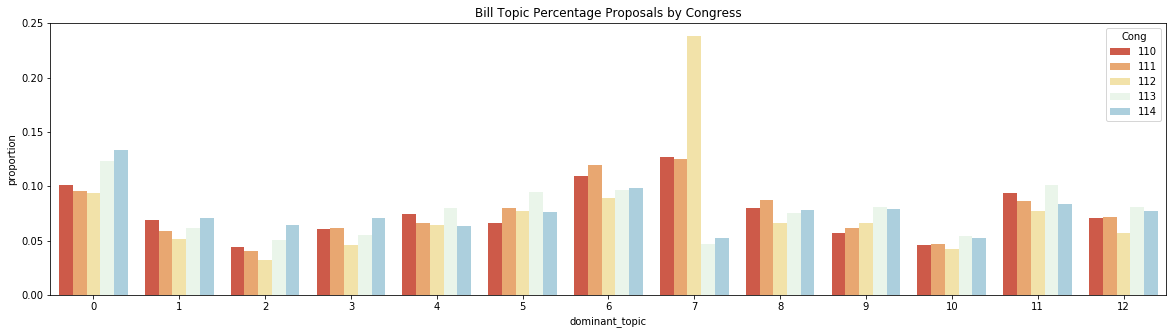

In [49]:
#Looking at dominant topic contribution by proportion
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(20,5))

x1, y1, hue = "dominant_topic", "proportion", "Cong"
hue_order = ["1", "0"]
data=topic_proportions

labels =['Immigration', '']

ax = (topic_proportions[x1]
 .groupby(topic_proportions[hue])
 .value_counts(normalize=True)
 .rename(y1)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x1, y=y1, hue=hue).set_title('Bill Topic Percentage Proposals by Congress'))

ax.set_xticklabels(final_topic_labels,  rotation="horizontal")

plt.show()

In [ ]:
topic_proportions['dominant_topic'].value_counts().plot.pie()

# **PyLDAvis Interactive Topic Model**



In [ ]:
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# pyLDAvis.enable_notebook()
# panel = pyLDAvis.sklearn.prepare(best_lda_model, transformed_pk, vectorizer_pk, mds='tsne')
# pyLDAvis.save_html(panel, 'PyLDAvis_visualization.html')
# panel

In [ ]:
filename3 = 'finalized_pyDavis_graph.sav'
pickle.dump(panel, open(filename3, 'wb'))
 

# **Visualization using SVD and Kmeans**

In [50]:
# Construct the k-means clusters
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()

sns.set_palette(sns.color_palette("RdYlBu"))

clusters = KMeans(n_clusters=13, random_state=2).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.26  0.12  0.09  0.09  0.14  0.18  0.22  0.84  0.16  0.14  0.08  0.2
   0.13]
 [-0.4  -0.16 -0.09 -0.13 -0.19 -0.24 -0.47  0.54 -0.26 -0.18 -0.11 -0.18
  -0.21]]
Perc of Variance Explained: 
 [0.07 0.11]


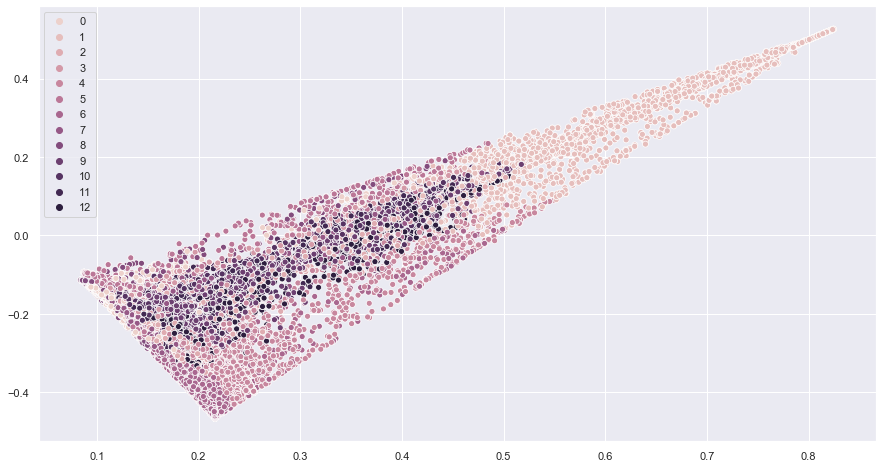

In [70]:
import matplotlib
palette = sns.color_palette("RdYlBu")
matplotlib.colors.to_rgba

cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)

x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

plt.figure(figsize=(15,8))
sns.scatterplot(x, y, hue=clusters, legend='full')


# **t-SNE**

The goal is to take a set of points in a high-dimensional space and find a faithful representation of those points in a lower-dimensional space, typically the 2D plane. The algorithm is non-linear and adapts to the underlying data, performing different transformations on different regions.

In [66]:
from sklearn.manifold import TSNE
# time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=300, random_state=2)
X_embedded = tsne.fit_transform(lda_output)
# print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 51067 samples in 0.080s...
[t-SNE] Computed neighbors for 51067 samples in 45.591s...
[t-SNE] Computed conditional probabilities for sample 1000 / 51067
[t-SNE] Computed conditional probabilities for sample 2000 / 51067
[t-SNE] Computed conditional probabilities for sample 3000 / 51067
[t-SNE] Computed conditional probabilities for sample 4000 / 51067
[t-SNE] Computed conditional probabilities for sample 5000 / 51067
[t-SNE] Computed conditional probabilities for sample 6000 / 51067
[t-SNE] Computed conditional probabilities for sample 7000 / 51067
[t-SNE] Computed conditional probabilities for sample 8000 / 51067
[t-SNE] Computed conditional probabilities for sample 9000 / 51067
[t-SNE] Computed conditional probabilities for sample 10000 / 51067
[t-SNE] Computed conditional probabilities for sample 11000 / 51067
[t-SNE] Computed conditional probabilities for sample 12000 / 51067
[t-SNE] Computed conditional probabilities for sa

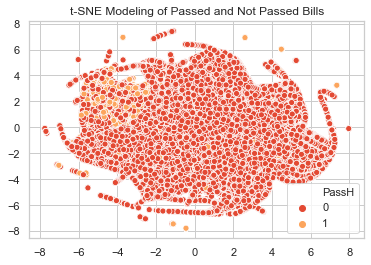

In [62]:
import seaborn as sns
from matplotlib import pyplot as plt
palette = sns.set_palette("RdYlBu")

# plt.figure(figsize=(15,8))
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full', palette=palette)
plt.title('t-SNE Modeling of Passed and Not Passed Bills')

plt.savefig('tsne_passh.png')

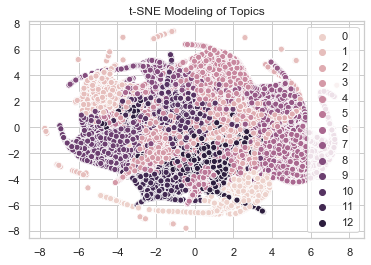

In [65]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_style("whitegrid")
sns.set_palette("RdYlBu")


# plt.figure(figsize=(15,8))

sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=clusters, legend='full')
plt.legend(loc='center right')
plt.title('t-SNE Modeling of Topics')
plt.savefig('tsne_topics.png')

In [74]:
import plotly.plotly as py
from plotly.graph_objs import 
py.sign_in('username', 'api_key')
trace1 = {
  "uid": "eb0a1b2b-600e-4b00-90ef-c1299cb6c72e", 
  "mode": "markers", 
  "type": "scatter", 
    "x": 'X_embedded[:,0]',
    "y":'X_embedded[:,1]',
 "marker": {"color": ["rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(165, 102, 198)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(93, 165, 149)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(170, 16, 99)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(162, 14, 193)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(198, 216, 21)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(170, 16, 99)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(181, 120, 208)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(170, 16, 99)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(203, 34, 28)", "rgb(60, 26, 192)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(223, 218, 244)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(223, 218, 244)", "rgb(223, 218, 244)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(60, 26, 192)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(223, 218, 244)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(129, 206, 186)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(181, 120, 208)", "rgb(181, 120, 208)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(171, 254, 108)", "rgb(151, 163, 73)", "rgb(151, 163, 73)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(244, 247, 142)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(0, 227, 247)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(7, 166, 148)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(130, 92, 233)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(0, 227, 247)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(7, 166, 148)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(138, 137, 249)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(0, 227, 247)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(0, 227, 247)", "rgb(0, 227, 247)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(7, 166, 148)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(60, 104, 118)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(101, 203, 203)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(45, 75, 210)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(23, 99, 119)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(4, 98, 159)", "rgb(134, 80, 10)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(209, 36, 161)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(134, 80, 10)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(198, 191, 220)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)", "rgb(186, 123, 44)"]}, 
  "text": ["British: HG00096", "British: HG00097", "British: HG00099", "British: HG00100", "British: HG00101", "British: HG00102", "British: HG00103", "British: HG00105", "British: HG00106", "British: HG00107", "British: HG00108", "British: HG00109", "British: HG00110", "British: HG00111", "British: HG00112", "British: HG00113", "British: HG00114", "British: HG00115", "British: HG00116", "British: HG00117", "British: HG00118", "British: HG00119", "British: HG00120", "British: HG00121", "British: HG00122", "British: HG00123", "British: HG00124", "British: HG00125", "British: HG00126", "British: HG00127", "British: HG00128", "British: HG00129", "British: HG00130", "British: HG00131", "British: HG00132", "British: HG00133", "British: HG00136", "British: HG00137", "British: HG00138", "British: HG00139", "British: HG00140", "British: HG00141", "British: HG00142", "British: HG00143", "British: HG00145", "British: HG00146", "British: HG00148", "British: HG00149", "British: HG00150", "British: HG00151", "British: HG00154", "British: HG00155", "British: HG00157", "British: HG00158", "British: HG00159", "British: HG00160", "Finnish: HG00171", "Finnish: HG00173", "Finnish: HG00174", "Finnish: HG00176", "Finnish: HG00177", "Finnish: HG00178", "Finnish: HG00179", "Finnish: HG00180", "Finnish: HG00181", "Finnish: HG00182", "Finnish: HG00183", "Finnish: HG00185", "Finnish: HG00186", "Finnish: HG00187", "Finnish: HG00188", "Finnish: HG00189", "Finnish: HG00190", "British: HG00231", "British: HG00232", "British: HG00233", "British: HG00234", "British: HG00235", "British: HG00236", "British: HG00237", "British: HG00238", "British: HG00239", "British: HG00240", "British: HG00242", "British: HG00243", "British: HG00244", "British: HG00245", "British: HG00246", "British: HG00250", "British: HG00251", "British: HG00252", "British: HG00253", "British: HG00254", "British: HG00255", "British: HG00256", "British: HG00257", "British: HG00258", "British: HG00259", "British: HG00260", "British: HG00261", "British: HG00262", "British: HG00263", "British: HG00264", "British: HG00265", "Finnish: HG00266", "Finnish: HG00267", "Finnish: HG00268", "Finnish: HG00269", "Finnish: HG00271", "Finnish: HG00272", "Finnish: HG00273", "Finnish: HG00274", "Finnish: HG00275", "Finnish: HG00276", "Finnish: HG00277", "Finnish: HG00278", "Finnish: HG00280", "Finnish: HG00281", "Finnish: HG00282", "Finnish: HG00284", "Finnish: HG00285", "Finnish: HG00288", "Finnish: HG00290", "Finnish: HG00304", "Finnish: HG00306", "Finnish: HG00308", "Finnish: HG00309", "Finnish: HG00310", "Finnish: HG00311", "Finnish: HG00313", "Finnish: HG00315", "Finnish: HG00318", "Finnish: HG00319", "Finnish: HG00320", "Finnish: HG00321", "Finnish: HG00323", "Finnish: HG00324", "Finnish: HG00325", "Finnish: HG00326", "Finnish: HG00327", "Finnish: HG00328", "Finnish: HG00329", "Finnish: HG00330", "Finnish: HG00331", "Finnish: HG00332", "Finnish: HG00334", "Finnish: HG00335", "Finnish: HG00336", "Finnish: HG00337", "Finnish: HG00338", "Finnish: HG00339", "Finnish: HG00341", "Finnish: HG00342", "Finnish: HG00343", "Finnish: HG00344", "Finnish: HG00345", "Finnish: HG00346", "Finnish: HG00349", "Finnish: HG00350", "Finnish: HG00351", "Finnish: HG00353", "Finnish: HG00355", "Finnish: HG00356", "Finnish: HG00357", "Finnish: HG00358", "Finnish: HG00360", "Finnish: HG00361", "Finnish: HG00362", "Finnish: HG00364", "Finnish: HG00365", "Finnish: HG00366", "Finnish: HG00367", "Finnish: HG00368", "Finnish: HG00369", "Finnish: HG00371", "Finnish: HG00372", "Finnish: HG00373", "Finnish: HG00375", "Finnish: HG00376", "Finnish: HG00378", "Finnish: HG00379", "Finnish: HG00380", "Finnish: HG00381", "Finnish: HG00382", "Finnish: HG00383", "Finnish: HG00384", "Southern Han Chinese: HG00403", "Southern Han Chinese: HG00404", "Southern Han Chinese: HG00406", "Southern Han Chinese: HG00407", "Southern Han Chinese: HG00409", "Southern Han Chinese: HG00410", "Southern Han Chinese: HG00419", "Southern Han Chinese: HG00421", "Southern Han Chinese: HG00422", "Southern Han Chinese: HG00428", "Southern Han Chinese: HG00436", "Southern Han Chinese: HG00437", "Southern Han Chinese: HG00442", "Southern Han Chinese: HG00443", "Southern Han Chinese: HG00445", "Southern Han Chinese: HG00446", "Southern Han Chinese: HG00448", "Southern Han Chinese: HG00449", "Southern Han Chinese: HG00451", "Southern Han Chinese: HG00452", "Southern Han Chinese: HG00457", "Southern Han Chinese: HG00458", "Southern Han Chinese: HG00463", "Southern Han Chinese: HG00464", "Southern Han Chinese: HG00472", "Southern Han Chinese: HG00473", "Southern Han Chinese: HG00475", "Southern Han Chinese: HG00476", "Southern Han Chinese: HG00478", "Southern Han Chinese: HG00479", "Southern Han Chinese: HG00500", "Southern Han Chinese: HG00501", "Southern Han Chinese: HG00513", "Southern Han Chinese: HG00524", "Southern Han Chinese: HG00525", "Southern Han Chinese: HG00530", "Southern Han Chinese: HG00531", "Southern Han Chinese: HG00533", "Southern Han Chinese: HG00534", "Southern Han Chinese: HG00536", "Southern Han Chinese: HG00537", "Southern Han Chinese: HG00542", "Southern Han Chinese: HG00543", "Puerto Rican: HG00551", "Puerto Rican: HG00553", "Puerto Rican: HG00554", "Southern Han Chinese: HG00556", "Southern Han Chinese: HG00557", "Southern Han Chinese: HG00559", "Southern Han Chinese: HG00560", "Southern Han Chinese: HG00565", "Southern Han Chinese: HG00566", "Southern Han Chinese: HG00580", "Southern Han Chinese: HG00581", "Southern Han Chinese: HG00583", "Southern Han Chinese: HG00584", "Southern Han Chinese: HG00589", "Southern Han Chinese: HG00590", "Southern Han Chinese: HG00592", "Southern Han Chinese: HG00593", "Southern Han Chinese: HG00595", "Southern Han Chinese: HG00596", "Southern Han Chinese: HG00598", "Southern Han Chinese: HG00599", "Southern Han Chinese: HG00607", "Southern Han Chinese: HG00608", "Southern Han Chinese: HG00610", "Southern Han Chinese: HG00611", "Southern Han Chinese: HG00613", "Southern Han Chinese: HG00614", "Southern Han Chinese: HG00619", "Southern Han Chinese: HG00620", "Southern Han Chinese: HG00622", "Southern Han Chinese: HG00623", "Southern Han Chinese: HG00625", "Southern Han Chinese: HG00626", "Southern Han Chinese: HG00628", "Southern Han Chinese: HG00629", "Southern Han Chinese: HG00631", "Southern Han Chinese: HG00632", "Southern Han Chinese: HG00634", "Southern Han Chinese: HG00635", "Puerto Rican: HG00637", "Puerto Rican: HG00638", "Puerto Rican: HG00640", "Puerto Rican: HG00641", "Southern Han Chinese: HG00650", "Southern Han Chinese: HG00651", "Southern Han Chinese: HG00653", "Southern Han Chinese: HG00654", "Southern Han Chinese: HG00656", "Southern Han Chinese: HG00657", "Southern Han Chinese: HG00662", "Southern Han Chinese: HG00663", "Southern Han Chinese: HG00671", "Southern Han Chinese: HG00672", "Southern Han Chinese: HG00674", "Southern Han Chinese: HG00675", "Southern Han Chinese: HG00683", "Southern Han Chinese: HG00684", "Southern Han Chinese: HG00689", "Southern Han Chinese: HG00690", "Southern Han Chinese: HG00692", "Southern Han Chinese: HG00693", "Southern Han Chinese: HG00698", "Southern Han Chinese: HG00699", "Southern Han Chinese: HG00701", "Southern Han Chinese: HG00702", "Southern Han Chinese: HG00704", "Southern Han Chinese: HG00705", "Southern Han Chinese: HG00707", "Southern Han Chinese: HG00708", "Southern Han Chinese: HG00717", "Southern Han Chinese: HG00728", "Southern Han Chinese: HG00729", "Puerto Rican: HG00731", "Puerto Rican: HG00732", "Puerto Rican: HG00733", "Puerto Rican: HG00734", "Puerto Rican: HG00736", "Puerto Rican: HG00737", "Puerto Rican: HG00739", "Puerto Rican: HG00740", "Puerto Rican: HG00742", "Puerto Rican: HG00743", "Dai Chinese: HG00759", "Dai Chinese: HG00766", "Dai Chinese: HG00844", "Dai Chinese: HG00851", "Dai Chinese: HG00864", "Dai Chinese: HG00867", "Dai Chinese: HG00879", "Dai Chinese: HG00881", "Dai Chinese: HG00956", "Dai Chinese: HG00978", "Dai Chinese: HG00982", "Dai Chinese: HG01028", "Dai Chinese: HG01029", "Dai Chinese: HG01031", "Dai Chinese: HG01046", "Puerto Rican: HG01047", "Puerto Rican: HG01048", "Puerto Rican: HG01049", "Puerto Rican: HG01051", "Puerto Rican: HG01052", "Puerto Rican: HG01054", "Puerto Rican: HG01055", "Puerto Rican: HG01058", "Puerto Rican: HG01060", "Puerto Rican: HG01061", "Puerto Rican: HG01063", "Puerto Rican: HG01064", "Puerto Rican: HG01066", "Puerto Rican: HG01067", "Puerto Rican: HG01069", "Puerto Rican: HG01070", "Puerto Rican: HG01072", "Puerto Rican: HG01073", "Puerto Rican: HG01075", "Puerto Rican: HG01077", "Puerto Rican: HG01079", "Puerto Rican: HG01080", "Puerto Rican: HG01082", "Puerto Rican: HG01083", "Puerto Rican: HG01085", "Puerto Rican: HG01086", "Puerto Rican: HG01088", "Puerto Rican: HG01089", "Puerto Rican: HG01092", "Puerto Rican: HG01094", "Puerto Rican: HG01095", "Puerto Rican: HG01097", "Puerto Rican: HG01098", "Puerto Rican: HG01101", "Puerto Rican: HG01102", "Puerto Rican: HG01104", "Puerto Rican: HG01105", "Puerto Rican: HG01107", "Puerto Rican: HG01108", "Puerto Rican: HG01110", "Puerto Rican: HG01111", "Colombian: HG01112", "Colombian: HG01113", "Colombian: HG01119", "Colombian: HG01121", "Colombian: HG01122", "Colombian: HG01124", "Colombian: HG01125", "Colombian: HG01130", "Colombian: HG01131", "Colombian: HG01133", "Colombian: HG01134", "Colombian: HG01136", "Colombian: HG01137", "Colombian: HG01139", "Colombian: HG01140", "Colombian: HG01142", "Colombian: HG01148", "Colombian: HG01149", "Puerto Rican: HG01161", "Puerto Rican: HG01162", "Puerto Rican: HG01164", "Puerto Rican: HG01167", "Puerto Rican: HG01168", "Puerto Rican: HG01170", "Puerto Rican: HG01171", "Puerto Rican: HG01173", "Puerto Rican: HG01174", "Puerto Rican: HG01176", "Puerto Rican: HG01177", "Puerto Rican: HG01182", "Puerto Rican: HG01183", "Puerto Rican: HG01187", "Puerto Rican: HG01188", "Puerto Rican: HG01190", "Puerto Rican: HG01191", "Puerto Rican: HG01197", "Puerto Rican: HG01198", "Puerto Rican: HG01200", "Puerto Rican: HG01204", "Puerto Rican: HG01205", "Puerto Rican: HG01241", "Puerto Rican: HG01242", "Puerto Rican: HG01247", "Puerto Rican: HG01248", "Colombian: HG01250", "Colombian: HG01251", "Colombian: HG01253", "Colombian: HG01254", "Colombian: HG01256", "Colombian: HG01257", "Colombian: HG01259", "Colombian: HG01260", "Colombian: HG01269", "Colombian: HG01271", "Colombian: HG01272", "Colombian: HG01275", "Colombian: HG01277", "Colombian: HG01280", "Colombian: HG01281", "Colombian: HG01284", "Puerto Rican: HG01286", "Puerto Rican: HG01302", "Puerto Rican: HG01303", "Puerto Rican: HG01305", "Puerto Rican: HG01308", "Puerto Rican: HG01311", "Puerto Rican: HG01312", "Puerto Rican: HG01323", "Puerto Rican: HG01325", "Puerto Rican: HG01326", "British: HG01334", "Colombian: HG01341", "Colombian: HG01342", "Colombian: HG01344", "Colombian: HG01345", "Colombian: HG01348", "Colombian: HG01350", "Colombian: HG01351", "Colombian: HG01353", "Colombian: HG01354", "Colombian: HG01356", "Colombian: HG01357", "Colombian: HG01359", "Colombian: HG01360", "Colombian: HG01362", "Colombian: HG01363", "Colombian: HG01365", "Colombian: HG01366", "Colombian: HG01369", "Colombian: HG01372", "Colombian: HG01374", "Colombian: HG01375", "Colombian: HG01377", "Colombian: HG01378", "Colombian: HG01383", "Colombian: HG01384", "Colombian: HG01389", "Colombian: HG01390", "Puerto Rican: HG01392", "Puerto Rican: HG01393", "Puerto Rican: HG01395", "Puerto Rican: HG01396", "Puerto Rican: HG01398", "Puerto Rican: HG01402", "Puerto Rican: HG01403", "Puerto Rican: HG01405", "Puerto Rican: HG01412", "Puerto Rican: HG01413", "Puerto Rican: HG01414", "Colombian: HG01431", "Colombian: HG01432", "Colombian: HG01435", "Colombian: HG01437", "Colombian: HG01438", "Colombian: HG01440", "Colombian: HG01441", "Colombian: HG01443", "Colombian: HG01444", "Colombian: HG01447", "Colombian: HG01455", "Colombian: HG01456", "Colombian: HG01459", "Colombian: HG01461", "Colombian: HG01462", "Colombian: HG01464", "Colombian: HG01465", "Colombian: HG01468", "Colombian: HG01474", "Colombian: HG01479", "Colombian: HG01485", "Colombian: HG01486", "Colombian: HG01488", "Colombian: HG01489", "Colombian: HG01491", "Colombian: HG01492", "Colombian: HG01494", "Colombian: HG01495", "Colombian: HG01497", "Colombian: HG01498", "Spanish: HG01500", "Spanish: HG01501", "Spanish: HG01503", "Spanish: HG01504", "Spanish: HG01506", "Spanish: HG01507", "Spanish: HG01509", "Spanish: HG01510", "Spanish: HG01512", "Spanish: HG01513", "Spanish: HG01515", "Spanish: HG01516", "Spanish: HG01518", "Spanish: HG01519", "Spanish: HG01521", "Spanish: HG01522", "Spanish: HG01524", "Spanish: HG01525", "Spanish: HG01527", "Spanish: HG01528", "Spanish: HG01530", "Spanish: HG01531", "Spanish: HG01536", "Spanish: HG01537", "Colombian: HG01550", "Colombian: HG01551", "Colombian: HG01556", "Peruvian: HG01565", "Peruvian: HG01566", "Peruvian: HG01571", "Peruvian: HG01572", "Peruvian: HG01577", "Peruvian: HG01578", "Punjabi: HG01583", "Punjabi: HG01586", "Punjabi: HG01589", "Punjabi: HG01593", "Kinh Vietnamese: HG01595", "Kinh Vietnamese: HG01596", "Kinh Vietnamese: HG01597", "Kinh Vietnamese: HG01598", "Kinh Vietnamese: HG01599", "Kinh Vietnamese: HG01600", "Spanish: HG01602", "Spanish: HG01603", "Spanish: HG01605", "Spanish: HG01606", "Spanish: HG01607", "Spanish: HG01608", "Spanish: HG01610", "Spanish: HG01612", "Spanish: HG01613", "Spanish: HG01615", "Spanish: HG01617", "Spanish: HG01618", "Spanish: HG01619", "Spanish: HG01620", "Spanish: HG01623", "Spanish: HG01624", "Spanish: HG01625", "Spanish: HG01626", "Spanish: HG01628", "Spanish: HG01630", "Spanish: HG01631", "Spanish: HG01632", "Spanish: HG01668", "Spanish: HG01669", "Spanish: HG01670", "Spanish: HG01672", "Spanish: HG01673", "Spanish: HG01675", "Spanish: HG01676", "Spanish: HG01678", "Spanish: HG01679", "Spanish: HG01680", "Spanish: HG01682", "Spanish: HG01684", "Spanish: HG01685", "Spanish: HG01686", "Spanish: HG01694", "Spanish: HG01695", "Spanish: HG01697", "Spanish: HG01699", "Spanish: HG01700", "Spanish: HG01702", "Spanish: HG01704", "Spanish: HG01705", "Spanish: HG01707", "Spanish: HG01708", "Spanish: HG01709", "Spanish: HG01710", "Spanish: HG01746", "Spanish: HG01747", "Spanish: HG01756", "Spanish: HG01757", "Spanish: HG01761", "Spanish: HG01762", "Spanish: HG01765", "Spanish: HG01766", "Spanish: HG01767", "Spanish: HG01768", "Spanish: HG01770", "Spanish: HG01771", "Spanish: HG01773", "Spanish: HG01775", "Spanish: HG01776", "Spanish: HG01777", "Spanish: HG01779", "Spanish: HG01781", "Spanish: HG01783", "Spanish: HG01784", "Spanish: HG01785", "Spanish: HG01786", "British: HG01789", "British: HG01790", "British: HG01791", "Dai Chinese: HG01794", "Dai Chinese: HG01795", "Dai Chinese: HG01796", "Dai Chinese: HG01797", "Dai Chinese: HG01798", "Dai Chinese: HG01799", "Dai Chinese: HG01800", "Dai Chinese: HG01801", "Dai Chinese: HG01802", "Dai Chinese: HG01804", "Dai Chinese: HG01805", "Dai Chinese: HG01806", "Dai Chinese: HG01807", "Dai Chinese: HG01808", "Dai Chinese: HG01809", "Dai Chinese: HG01810", "Dai Chinese: HG01811", "Dai Chinese: HG01812", "Dai Chinese: HG01813", "Dai Chinese: HG01815", "Dai Chinese: HG01816", "Dai Chinese: HG01817", "Kinh Vietnamese: HG01840", "Kinh Vietnamese: HG01841", "Kinh Vietnamese: HG01842", "Kinh Vietnamese: HG01843", "Kinh Vietnamese: HG01844", "Kinh Vietnamese: HG01845", "Kinh Vietnamese: HG01846", "Kinh Vietnamese: HG01847", "Kinh Vietnamese: HG01848", "Kinh Vietnamese: HG01849", "Kinh Vietnamese: HG01850", "Kinh Vietnamese: HG01851", "Kinh Vietnamese: HG01852", "Kinh Vietnamese: HG01853", "Kinh Vietnamese: HG01855", "Kinh Vietnamese: HG01857", "Kinh Vietnamese: HG01858", "Kinh Vietnamese: HG01859", "Kinh Vietnamese: HG01860", "Kinh Vietnamese: HG01861", "Kinh Vietnamese: HG01862", "Kinh Vietnamese: HG01863", "Kinh Vietnamese: HG01864", "Kinh Vietnamese: HG01865", "Kinh Vietnamese: HG01866", "Kinh Vietnamese: HG01867", "Kinh Vietnamese: HG01868", "Kinh Vietnamese: HG01869", "Kinh Vietnamese: HG01870", "Kinh Vietnamese: HG01871", "Kinh Vietnamese: HG01872", "Kinh Vietnamese: HG01873", "Kinh Vietnamese: HG01874", "Kinh Vietnamese: HG01878", "African-Caribbean: HG01879", "African-Caribbean: HG01880", "African-Caribbean: HG01882", "African-Caribbean: HG01883", "African-Caribbean: HG01885", "African-Caribbean: HG01886", "African-Caribbean: HG01889", "African-Caribbean: HG01890", "Peruvian: HG01892", "Peruvian: HG01893", "African-Caribbean: HG01894", "African-Caribbean: HG01896", "African-Caribbean: HG01912", "African-Caribbean: HG01914", "African-Caribbean: HG01915", "Peruvian: HG01917", "Peruvian: HG01918", "Peruvian: HG01920", "Peruvian: HG01921", "Peruvian: HG01923", "Peruvian: HG01924", "Peruvian: HG01926", "Peruvian: HG01927", "Peruvian: HG01932", "Peruvian: HG01933", "Peruvian: HG01935", "Peruvian: HG01936", "Peruvian: HG01938", "Peruvian: HG01939", "Peruvian: HG01941", "Peruvian: HG01942", "Peruvian: HG01944", "Peruvian: HG01945", "Peruvian: HG01947", "Peruvian: HG01948", "Peruvian: HG01950", "Peruvian: HG01951", "Peruvian: HG01953", "Peruvian: HG01954", "African-Caribbean: HG01956", "African-Caribbean: HG01958", "Peruvian: HG01961", "Peruvian: HG01965", "Peruvian: HG01967", "Peruvian: HG01968", "Peruvian: HG01970", "Peruvian: HG01971", "Peruvian: HG01973", "Peruvian: HG01974", "Peruvian: HG01976", "Peruvian: HG01977", "Peruvian: HG01979", "Peruvian: HG01980", "Peruvian: HG01982", "Peruvian: HG01983", "African-Caribbean: HG01985", "African-Caribbean: HG01986", "African-Caribbean: HG01988", "African-Caribbean: HG01989", "African-Caribbean: HG01990", "Peruvian: HG01991", "Peruvian: HG01992", "Peruvian: HG01997", "Peruvian: HG02002", "Peruvian: HG02003", "Peruvian: HG02006", "Peruvian: HG02008", "African-Caribbean: HG02009", "African-Caribbean: HG02010", "African-Caribbean: HG02012", "African-Caribbean: HG02013", "African-Caribbean: HG02014", "Kinh Vietnamese: HG02016", "Kinh Vietnamese: HG02017", "Kinh Vietnamese: HG02019", "Kinh Vietnamese: HG02020", "Kinh Vietnamese: HG02023", "Kinh Vietnamese: HG02024", "Kinh Vietnamese: HG02025", "Kinh Vietnamese: HG02026", "Kinh Vietnamese: HG02028", "Kinh Vietnamese: HG02029", "Kinh Vietnamese: HG02031", "Kinh Vietnamese: HG02032", "Kinh Vietnamese: HG02035", "Kinh Vietnamese: HG02040", "Kinh Vietnamese: HG02046", "Kinh Vietnamese: HG02047", "Kinh Vietnamese: HG02048", "Kinh Vietnamese: HG02049", "Kinh Vietnamese: HG02050", "African-Caribbean: HG02051", "African-Caribbean: HG02052", "African-Caribbean: HG02053", "African-Caribbean: HG02054", "Kinh Vietnamese: HG02057", "Kinh Vietnamese: HG02058", "Kinh Vietnamese: HG02060", "Kinh Vietnamese: HG02061", "Kinh Vietnamese: HG02064", "Kinh Vietnamese: HG02067", "Kinh Vietnamese: HG02069", "Kinh Vietnamese: HG02070", "Kinh Vietnamese: HG02072", "Kinh Vietnamese: HG02073", "Kinh Vietnamese: HG02075", "Kinh Vietnamese: HG02076", "Kinh Vietnamese: HG02078", "Kinh Vietnamese: HG02079", "Kinh Vietnamese: HG02081", "Kinh Vietnamese: HG02082", "Kinh Vietnamese: HG02084", "Kinh Vietnamese: HG02085", "Kinh Vietnamese: HG02086", "Kinh Vietnamese: HG02087", "Kinh Vietnamese: HG02088", "Peruvian: HG02089", "Peruvian: HG02090", "African-Caribbean: HG02095", "Peruvian: HG02102", "Peruvian: HG02104", "Peruvian: HG02105", "African-Caribbean: HG02107", "African-Caribbean: HG02108", "African-Caribbean: HG02111", "Kinh Vietnamese: HG02113", "Kinh Vietnamese: HG02116", "Kinh Vietnamese: HG02121", "Kinh Vietnamese: HG02122", "Kinh Vietnamese: HG02127", "Kinh Vietnamese: HG02128", "Kinh Vietnamese: HG02130", "Kinh Vietnamese: HG02131", "Kinh Vietnamese: HG02133", "Kinh Vietnamese: HG02134", "Kinh Vietnamese: HG02136", "Kinh Vietnamese: HG02137", "Kinh Vietnamese: HG02138", "Kinh Vietnamese: HG02139", "Kinh Vietnamese: HG02140", "Kinh Vietnamese: HG02141", "Kinh Vietnamese: HG02142", "African-Caribbean: HG02143", "African-Caribbean: HG02144", "Peruvian: HG02146", "Peruvian: HG02147", "Peruvian: HG02150", "Dai Chinese: HG02151", "Dai Chinese: HG02152", "Dai Chinese: HG02153", "Dai Chinese: HG02154", "Dai Chinese: HG02155", "Dai Chinese: HG02156", "Dai Chinese: HG02164", "Dai Chinese: HG02165", "Dai Chinese: HG02166", "Dai Chinese: HG02178", "Dai Chinese: HG02179", "Dai Chinese: HG02180", "Dai Chinese: HG02181", "Dai Chinese: HG02182", "Dai Chinese: HG02184", "Dai Chinese: HG02185", "Dai Chinese: HG02186", "Dai Chinese: HG02187", "Dai Chinese: HG02188", "Dai Chinese: HG02190", "British: HG02215", "Spanish: HG02219", "Spanish: HG02220", "Spanish: HG02221", "Spanish: HG02223", "Spanish: HG02224", "Spanish: HG02230", "Spanish: HG02231", "Spanish: HG02232", "Spanish: HG02233", "Spanish: HG02235", "Spanish: HG02236", "Spanish: HG02238", "Spanish: HG02239", "Dai Chinese: HG02250", "Peruvian: HG02252", "Peruvian: HG02253", "African-Caribbean: HG02255", "African-Caribbean: HG02256", "Peruvian: HG02259", "Peruvian: HG02260", "Peruvian: HG02262", "Peruvian: HG02265", "Peruvian: HG02266", "Peruvian: HG02271", "Peruvian: HG02272", "Peruvian: HG02274", "Peruvian: HG02275", "Peruvian: HG02277", "Peruvian: HG02278", "African-Caribbean: HG02281", "African-Caribbean: HG02282", "African-Caribbean: HG02283", "African-Caribbean: HG02284", "Peruvian: HG02285", "Peruvian: HG02286", "Peruvian: HG02291", "Peruvian: HG02292", "Peruvian: HG02298", "Peruvian: HG02299", "Peruvian: HG02301", "Peruvian: HG02304", "African-Caribbean: HG02307", "African-Caribbean: HG02308", "African-Caribbean: HG02309", "Peruvian: HG02312", "African-Caribbean: HG02314", "African-Caribbean: HG02315", "African-Caribbean: HG02317", "African-Caribbean: HG02318", "African-Caribbean: HG02322", "African-Caribbean: HG02323", "African-Caribbean: HG02325", "African-Caribbean: HG02330", "African-Caribbean: HG02332", "African-Caribbean: HG02334", "African-Caribbean: HG02337", "African-Caribbean: HG02339", "African-Caribbean: HG02343", "Peruvian: HG02345", "Peruvian: HG02348", "Dai Chinese: HG02351", "Dai Chinese: HG02353", "Dai Chinese: HG02355", "Dai Chinese: HG02356", "Dai Chinese: HG02360", "Dai Chinese: HG02363", "Dai Chinese: HG02364", "Dai Chinese: HG02367", "Dai Chinese: HG02371", "Dai Chinese: HG02372", "Dai Chinese: HG02373", "Dai Chinese: HG02374", "Dai Chinese: HG02375", "Dai Chinese: HG02377", "Dai Chinese: HG02379", "Dai Chinese: HG02380", "Dai Chinese: HG02381", "Dai Chinese: HG02382", "Dai Chinese: HG02383", "Dai Chinese: HG02384", "Dai Chinese: HG02385", "Dai Chinese: HG02386", "Dai Chinese: HG02387", "Dai Chinese: HG02388", "Dai Chinese: HG02389", "Dai Chinese: HG02390", "Dai Chinese: HG02391", "Dai Chinese: HG02392", "Dai Chinese: HG02394", "Dai Chinese: HG02395", "Dai Chinese: HG02396", "Dai Chinese: HG02397", "Dai Chinese: HG02398", "Dai Chinese: HG02399", "Dai Chinese: HG02401", "Dai Chinese: HG02402", "Dai Chinese: HG02406", "Dai Chinese: HG02407", "Dai Chinese: HG02408", "Dai Chinese: HG02409", "Dai Chinese: HG02410", "African-Caribbean: HG02419", "African-Caribbean: HG02420", "Peruvian: HG02425", "African-Caribbean: HG02427", "African-Caribbean: HG02429", "African-Caribbean: HG02433", "African-Caribbean: HG02439", "African-Caribbean: HG02442", "African-Caribbean: HG02445", "African-Caribbean: HG02449", "African-Caribbean: HG02450", "African-Caribbean: HG02455", "Gambian Mandinka: HG02461", "Gambian Mandinka: HG02462", "Gambian Mandinka: HG02464", "Gambian Mandinka: HG02465", "African-Caribbean: HG02470", "African-Caribbean: HG02471", "African-Caribbean: HG02476", "African-Caribbean: HG02477", "African-Caribbean: HG02479", "African-Caribbean: HG02481", "African-Caribbean: HG02484", "African-Caribbean: HG02485", "African-Caribbean: HG02489", "Punjabi: HG02490", "Punjabi: HG02491", "Punjabi: HG02493", "Punjabi: HG02494", "African-Caribbean: HG02496", "African-Caribbean: HG02497", "African-Caribbean: HG02501", "African-Caribbean: HG02502", "African-Caribbean: HG02505", "African-Caribbean: HG02508", "African-Caribbean: HG02511", "Kinh Vietnamese: HG02512", "Kinh Vietnamese: HG02513", "Kinh Vietnamese: HG02521", "Kinh Vietnamese: HG02522", "African-Caribbean: HG02536", "African-Caribbean: HG02537", "African-Caribbean: HG02541", "African-Caribbean: HG02545", "African-Caribbean: HG02546", "African-Caribbean: HG02549", "African-Caribbean: HG02554", "African-Caribbean: HG02555", "African-Caribbean: HG02557", "African-Caribbean: HG02558", "Gambian Mandinka: HG02561", "Gambian Mandinka: HG02562", "Gambian Mandinka: HG02568", "Gambian Mandinka: HG02570", "Gambian Mandinka: HG02571", "Gambian Mandinka: HG02573", "Gambian Mandinka: HG02574", "African-Caribbean: HG02577", "African-Caribbean: HG02580", "Gambian Mandinka: HG02582", "Gambian Mandinka: HG02583", "Gambian Mandinka: HG02585", "Gambian Mandinka: HG02586", "Gambian Mandinka: HG02588", "Gambian Mandinka: HG02589", "Gambian Mandinka: HG02594", "Gambian Mandinka: HG02595", "Punjabi: HG02597", "Punjabi: HG02600", "Punjabi: HG02601", "Punjabi: HG02603", "Punjabi: HG02604", "Gambian Mandinka: HG02610", "Gambian Mandinka: HG02611", "Gambian Mandinka: HG02613", "Gambian Mandinka: HG02614", "Gambian Mandinka: HG02620", "Gambian Mandinka: HG02621", "Gambian Mandinka: HG02623", "Gambian Mandinka: HG02624", "Gambian Mandinka: HG02628", "Gambian Mandinka: HG02629", "Gambian Mandinka: HG02634", "Gambian Mandinka: HG02635", "Gambian Mandinka: HG02642", "Gambian Mandinka: HG02643", "Gambian Mandinka: HG02645", "Gambian Mandinka: HG02646", "Punjabi: HG02648", "Punjabi: HG02649", "Punjabi: HG02651", "Punjabi: HG02652", "Punjabi: HG02654", "Punjabi: HG02655", "Punjabi: HG02657", "Punjabi: HG02658", "Punjabi: HG02660", "Punjabi: HG02661", "Gambian Mandinka: HG02666", "Gambian Mandinka: HG02667", "Gambian Mandinka: HG02675", "Gambian Mandinka: HG02676", "Gambian Mandinka: HG02678", "Gambian Mandinka: HG02679", "Punjabi: HG02681", "Punjabi: HG02682", "Punjabi: HG02684", "Punjabi: HG02685", "Punjabi: HG02687", "Punjabi: HG02688", "Punjabi: HG02690", "Punjabi: HG02691", "Punjabi: HG02694", "Punjabi: HG02696", "Punjabi: HG02697", "Punjabi: HG02699", "Punjabi: HG02700", "Gambian Mandinka: HG02702", "Gambian Mandinka: HG02703", "Gambian Mandinka: HG02715", "Gambian Mandinka: HG02716", "Gambian Mandinka: HG02721", "Gambian Mandinka: HG02722", "Punjabi: HG02724", "Punjabi: HG02725", "Punjabi: HG02727", "Punjabi: HG02728", "Punjabi: HG02731", "Punjabi: HG02733", "Punjabi: HG02734", "Punjabi: HG02736", "Punjabi: HG02737", "Gambian Mandinka: HG02756", "Gambian Mandinka: HG02757", "Gambian Mandinka: HG02759", "Gambian Mandinka: HG02760", "Gambian Mandinka: HG02763", "Gambian Mandinka: HG02768", "Gambian Mandinka: HG02769", "Gambian Mandinka: HG02771", "Gambian Mandinka: HG02772", "Punjabi: HG02774", "Punjabi: HG02775", "Punjabi: HG02778", "Punjabi: HG02780", "Punjabi: HG02783", "Punjabi: HG02784", "Punjabi: HG02786", "Punjabi: HG02787", "Punjabi: HG02789", "Punjabi: HG02790", "Punjabi: HG02792", "Punjabi: HG02793", "Gambian Mandinka: HG02798", "Gambian Mandinka: HG02799", "Gambian Mandinka: HG02804", "Gambian Mandinka: HG02805", "Gambian Mandinka: HG02807", "Gambian Mandinka: HG02808", "Gambian Mandinka: HG02810", "Gambian Mandinka: HG02811", "Gambian Mandinka: HG02813", "Gambian Mandinka: HG02814", "Gambian Mandinka: HG02816", "Gambian Mandinka: HG02817", "Gambian Mandinka: HG02819", "Gambian Mandinka: HG02820", "Gambian Mandinka: HG02836", "Gambian Mandinka: HG02837", "Gambian Mandinka: HG02839", "Gambian Mandinka: HG02840", "Gambian Mandinka: HG02851", "Gambian Mandinka: HG02852", "Gambian Mandinka: HG02854", "Gambian Mandinka: HG02855", "Gambian Mandinka: HG02860", "Gambian Mandinka: HG02861", "Gambian Mandinka: HG02870", "Gambian Mandinka: HG02878", "Gambian Mandinka: HG02879", "Gambian Mandinka: HG02881", "Gambian Mandinka: HG02882", "Gambian Mandinka: HG02884", "Gambian Mandinka: HG02885", "Gambian Mandinka: HG02887", "Gambian Mandinka: HG02888", "Gambian Mandinka: HG02890", "Gambian Mandinka: HG02891", "Gambian Mandinka: HG02895", "Gambian Mandinka: HG02896", "Esan: HG02922", "Esan: HG02923", "Esan: HG02938", "Esan: HG02941", "Esan: HG02943", "Esan: HG02944", "Esan: HG02946", "Esan: HG02947", "Esan: HG02952", "Esan: HG02953", "Esan: HG02968", "Esan: HG02970", "Esan: HG02971", "Esan: HG02973", "Esan: HG02974", "Esan: HG02976", "Esan: HG02977", "Esan: HG02979", "Esan: HG02981", "Gambian Mandinka: HG02982", "Gambian Mandinka: HG02983", "Bengali: HG03006", "Bengali: HG03007", "Bengali: HG03009", "Bengali: HG03012", "Punjabi: HG03015", "Punjabi: HG03016", "Punjabi: HG03018", "Punjabi: HG03019", "Punjabi: HG03021", "Punjabi: HG03022", "Gambian Mandinka: HG03024", "Gambian Mandinka: HG03025", "Gambian Mandinka: HG03027", "Gambian Mandinka: HG03028", "Gambian Mandinka: HG03039", "Gambian Mandinka: HG03040", "Gambian Mandinka: HG03045", "Gambian Mandinka: HG03046", "Gambian Mandinka: HG03048", "Gambian Mandinka: HG03049", "Mende: HG03052", "Mende: HG03054", "Mende: HG03055", "Mende: HG03057", "Mende: HG03058", "Mende: HG03060", "Mende: HG03061", "Mende: HG03063", "Mende: HG03064", "Mende: HG03066", "Mende: HG03069", "Mende: HG03072", "Mende: HG03073", "Mende: HG03074", "Mende: HG03077", "Mende: HG03078", "Mende: HG03079", "Mende: HG03081", "Mende: HG03082", "Mende: HG03084", "Mende: HG03085", "Mende: HG03086", "Mende: HG03088", "Mende: HG03091", "Mende: HG03095", "Mende: HG03096", "Mende: HG03097", "Esan: HG03099", "Esan: HG03100", "Esan: HG03103", "Esan: HG03105", "Esan: HG03108", "Esan: HG03109", "Esan: HG03111", "Esan: HG03112", "Esan: HG03114", "Esan: HG03115", "Esan: HG03117", "Esan: HG03118", "Esan: HG03120", "Esan: HG03121", "Esan: HG03123", "Esan: HG03124", "Esan: HG03126", "Esan: HG03127", "Esan: HG03129", "Esan: HG03130", "Esan: HG03132", "Esan: HG03133", "Esan: HG03135", "Esan: HG03136", "Esan: HG03139", "Esan: HG03157", "Esan: HG03159", "Esan: HG03160", "Esan: HG03162", "Esan: HG03163", "Esan: HG03166", "Esan: HG03168", "Esan: HG03169", "Esan: HG03172", "Esan: HG03175", "Esan: HG03189", "Esan: HG03190", "Esan: HG03193", "Esan: HG03195", "Esan: HG03196", "Esan: HG03198", "Esan: HG03199", "Esan: HG03202", "Mende: HG03209", "Mende: HG03212", "Mende: HG03224", "Mende: HG03225", "Punjabi: HG03228", "Punjabi: HG03229", "Punjabi: HG03234", "Punjabi: HG03235", "Punjabi: HG03237", "Punjabi: HG03238", "Gambian Mandinka: HG03240", "Gambian Mandinka: HG03241", "Gambian Mandinka: HG03246", "Gambian Mandinka: HG03247", "Gambian Mandinka: HG03258", "Gambian Mandinka: HG03259", "Esan: HG03265", "Esan: HG03267", "Esan: HG03268", "Esan: HG03270", "Esan: HG03271", "Esan: HG03279", "Esan: HG03280", "Esan: HG03291", "Esan: HG03294", "Esan: HG03295", "Esan: HG03297", "Esan: HG03298", "Esan: HG03300", "Esan: HG03301", "Esan: HG03303", "Esan: HG03304", "Esan: HG03311", "Esan: HG03313", "Esan: HG03342", "Esan: HG03343", "Esan: HG03351", "Esan: HG03352", "Esan: HG03354", "Esan: HG03363", "Esan: HG03366", "Esan: HG03367", "Esan: HG03369", "Esan: HG03370", "Esan: HG03372", "Mende: HG03376", "Mende: HG03378", "Mende: HG03380", "Mende: HG03382", "Mende: HG03385", "Mende: HG03388", "Mende: HG03391", "Mende: HG03394", "Mende: HG03397", "Mende: HG03401", "Mende: HG03410", "Mende: HG03419", "Mende: HG03428", "Mende: HG03432", "Mende: HG03433", "Mende: HG03436", "Mende: HG03437", "Mende: HG03439", "Mende: HG03442", "Mende: HG03445", "Mende: HG03446", "Mende: HG03449", "Mende: HG03451", "Mende: HG03452", "Mende: HG03455", "Mende: HG03457", "Mende: HG03458", "Mende: HG03460", "Mende: HG03461", "Mende: HG03464", "Mende: HG03469", "Mende: HG03470", "Mende: HG03472", "Mende: HG03473", "Mende: HG03476", "Mende: HG03478", "Mende: HG03479", "Mende: HG03484", "Mende: HG03485", "Punjabi: HG03488", "Punjabi: HG03490", "Punjabi: HG03491", "Esan: HG03499", "Esan: HG03511", "Esan: HG03514", "Esan: HG03515", "Esan: HG03517", "Esan: HG03518", "Esan: HG03520", "Esan: HG03521", "Gambian Mandinka: HG03538", "Gambian Mandinka: HG03539", "Mende: HG03547", "Mende: HG03548", "Mende: HG03556", "Mende: HG03557", "Mende: HG03558", "Mende: HG03559", "Mende: HG03563", "Mende: HG03565", "Mende: HG03567", "Mende: HG03571", "Mende: HG03572", "Mende: HG03575", "Mende: HG03577", "Mende: HG03578", "Mende: HG03583", "Bengali: HG03585", "Bengali: HG03589", "Bengali: HG03593", "Bengali: HG03594", "Bengali: HG03595", "Bengali: HG03598", "Bengali: HG03600", "Bengali: HG03603", "Bengali: HG03604", "Bengali: HG03607", "Bengali: HG03611", "Bengali: HG03615", "Bengali: HG03616", "Punjabi: HG03619", "Punjabi: HG03624", "Punjabi: HG03625", "Punjabi: HG03629", "Punjabi: HG03631", "Punjabi: HG03634", "Punjabi: HG03636", "Punjabi: HG03640", "Sri Lankan: HG03642", "Sri Lankan: HG03643", "Sri Lankan: HG03644", "Sri Lankan: HG03645", "Sri Lankan: HG03646", "Punjabi: HG03649", "Punjabi: HG03652", "Punjabi: HG03653", "Punjabi: HG03660", "Punjabi: HG03663", "Punjabi: HG03667", "Punjabi: HG03668", "Sri Lankan: HG03672", "Sri Lankan: HG03673", "Sri Lankan: HG03679", "Sri Lankan: HG03680", "Sri Lankan: HG03681", "Sri Lankan: HG03684", "Sri Lankan: HG03685", "Sri Lankan: HG03686", "Sri Lankan: HG03687", "Sri Lankan: HG03689", "Sri Lankan: HG03690", "Sri Lankan: HG03691", "Sri Lankan: HG03692", "Sri Lankan: HG03693", "Sri Lankan: HG03694", "Sri Lankan: HG03695", "Sri Lankan: HG03696", "Sri Lankan: HG03697", "Sri Lankan: HG03698", "Punjabi: HG03702", "Punjabi: HG03703", "Punjabi: HG03705", "Punjabi: HG03706", "Punjabi: HG03708", "Punjabi: HG03709", "Sri Lankan: HG03711", "Indian: HG03713", "Indian: HG03714", "Indian: HG03715", "Indian: HG03716", "Indian: HG03717", "Indian: HG03718", "Indian: HG03720", "Indian: HG03722", "Indian: HG03727", "Indian: HG03729", "Indian: HG03730", "Indian: HG03731", "Sri Lankan: HG03733", "Sri Lankan: HG03736", "Sri Lankan: HG03738", "Sri Lankan: HG03740", "Sri Lankan: HG03741", "Indian: HG03742", "Sri Lankan: HG03743", "Sri Lankan: HG03744", "Sri Lankan: HG03745", "Sri Lankan: HG03746", "Sri Lankan: HG03750", "Sri Lankan: HG03752", "Sri Lankan: HG03753", "Sri Lankan: HG03754", "Sri Lankan: HG03755", "Sri Lankan: HG03756", "Sri Lankan: HG03757", "Sri Lankan: HG03760", "Punjabi: HG03762", "Punjabi: HG03765", "Punjabi: HG03767", "Indian: HG03770", "Indian: HG03771", "Indian: HG03772", "Indian: HG03773", "Indian: HG03774", "Indian: HG03775", "Indian: HG03777", "Indian: HG03778", "Indian: HG03779", "Indian: HG03780", "Indian: HG03781", "Indian: HG03782", "Indian: HG03784", "Indian: HG03785", "Indian: HG03786", "Indian: HG03787", "Indian: HG03788", "Indian: HG03789", "Indian: HG03790", "Indian: HG03792", "Bengali: HG03793", "Bengali: HG03796", "Bengali: HG03800", "Bengali: HG03802", "Bengali: HG03803", "Bengali: HG03805", "Bengali: HG03808", "Bengali: HG03809", "Bengali: HG03812", "Bengali: HG03814", "Bengali: HG03815", "Bengali: HG03817", "Bengali: HG03821", "Bengali: HG03823", "Bengali: HG03824", "Bengali: HG03826", "Bengali: HG03829", "Bengali: HG03830", "Bengali: HG03832", "Bengali: HG03833", "Sri Lankan: HG03836", "Sri Lankan: HG03837", "Sri Lankan: HG03838", "Sri Lankan: HG03844", "Sri Lankan: HG03846", "Sri Lankan: HG03848", "Sri Lankan: HG03849", "Sri Lankan: HG03850", "Sri Lankan: HG03851", "Sri Lankan: HG03854", "Sri Lankan: HG03856", "Sri Lankan: HG03857", "Sri Lankan: HG03858", "Indian: HG03861", "Indian: HG03862", "Indian: HG03863", "Indian: HG03864", "Indian: HG03866", "Indian: HG03867", "Indian: HG03868", "Indian: HG03869", "Indian: HG03870", "Indian: HG03871", "Indian: HG03872", "Indian: HG03873", "Indian: HG03874", "Indian: HG03875", "Indian: HG03882", "Sri Lankan: HG03884", "Sri Lankan: HG03885", "Sri Lankan: HG03886", "Sri Lankan: HG03887", "Sri Lankan: HG03888", "Sri Lankan: HG03890", "Sri Lankan: HG03894", "Sri Lankan: HG03895", "Sri Lankan: HG03896", "Sri Lankan: HG03897", "Sri Lankan: HG03898", "Sri Lankan: HG03899", "Sri Lankan: HG03900", "Bengali: HG03902", "Bengali: HG03905", "Bengali: HG03907", "Bengali: HG03908", "Bengali: HG03910", "Bengali: HG03911", "Bengali: HG03913", "Bengali: HG03914", "Bengali: HG03916", "Bengali: HG03917", "Bengali: HG03919", "Bengali: HG03920", "Bengali: HG03922", "Bengali: HG03925", "Bengali: HG03926", "Bengali: HG03928", "Bengali: HG03931", "Bengali: HG03934", "Bengali: HG03937", "Bengali: HG03940", "Bengali: HG03941", "Sri Lankan: HG03943", "Sri Lankan: HG03944", "Sri Lankan: HG03945", "Sri Lankan: HG03947", "Sri Lankan: HG03948", "Sri Lankan: HG03949", "Sri Lankan: HG03950", "Sri Lankan: HG03951", "Sri Lankan: HG03953", "Sri Lankan: HG03955", "Indian: HG03960", "Indian: HG03963", "Indian: HG03965", "Indian: HG03967", "Indian: HG03968", "Indian: HG03969", "Indian: HG03971", "Indian: HG03973", "Indian: HG03974", "Indian: HG03976", "Indian: HG03977", "Indian: HG03978", "Sri Lankan: HG03985", "Sri Lankan: HG03986", "Sri Lankan: HG03989", "Sri Lankan: HG03990", "Sri Lankan: HG03991", "Sri Lankan: HG03995", "Sri Lankan: HG03998", "Sri Lankan: HG03999", "Indian: HG04001", "Indian: HG04002", "Sri Lankan: HG04003", "Sri Lankan: HG04006", "Indian: HG04014", "Indian: HG04015", "Indian: HG04017", "Indian: HG04018", "Indian: HG04019", "Indian: HG04020", "Indian: HG04022", "Indian: HG04023", "Indian: HG04025", "Indian: HG04026", "Sri Lankan: HG04029", "Sri Lankan: HG04033", "Sri Lankan: HG04035", "Sri Lankan: HG04038", "Sri Lankan: HG04039", "Sri Lankan: HG04042", "Sri Lankan: HG04047", "Indian: HG04054", "Indian: HG04056", "Indian: HG04059", "Indian: HG04060", "Indian: HG04061", "Indian: HG04062", "Indian: HG04063", "Indian: HG04070", "Sri Lankan: HG04075", "Indian: HG04076", "Indian: HG04080", "Indian: HG04090", "Indian: HG04093", "Indian: HG04094", "Indian: HG04096", "Indian: HG04098", "Sri Lankan: HG04099", "Sri Lankan: HG04100", "Sri Lankan: HG04106", "Sri Lankan: HG04107", "Indian: HG04118", "Bengali: HG04131", "Bengali: HG04134", "Bengali: HG04140", "Bengali: HG04141", "Bengali: HG04144", "Bengali: HG04146", "Bengali: HG04152", "Bengali: HG04153", "Bengali: HG04155", "Bengali: HG04156", "Bengali: HG04158", "Bengali: HG04159", "Bengali: HG04161", "Bengali: HG04162", "Bengali: HG04164", "Bengali: HG04171", "Bengali: HG04173", "Bengali: HG04176", "Bengali: HG04177", "Bengali: HG04180", "Bengali: HG04182", "Bengali: HG04183", "Bengali: HG04185", "Bengali: HG04186", "Bengali: HG04188", "Bengali: HG04189", "Bengali: HG04194", "Bengali: HG04195", "Indian: HG04198", "Indian: HG04200", "Indian: HG04202", "Indian: HG04206", "Indian: HG04209", "Sri Lankan: HG04210", "Indian: HG04211", "Indian: HG04212", "Indian: HG04214", "Indian: HG04216", "Indian: HG04219", "Indian: HG04222", "Indian: HG04225", "Sri Lankan: HG04227", "Sri Lankan: HG04229", "Indian: HG04235", "Indian: HG04238", "Indian: HG04239", "CEPH: NA06984", "CEPH: NA06985", "CEPH: NA06986", "CEPH: NA06989", "CEPH: NA06994", "CEPH: NA07000", "CEPH: NA07037", "CEPH: NA07048", "CEPH: NA07051", "CEPH: NA07056", "CEPH: NA07347", "CEPH: NA07357", "CEPH: NA10847", "CEPH: NA10851", "CEPH: NA11829", "CEPH: NA11830", "CEPH: NA11831", "CEPH: NA11832", "CEPH: NA11840", "CEPH: NA11843", "CEPH: NA11881", "CEPH: NA11892", "CEPH: NA11893", "CEPH: NA11894", "CEPH: NA11918", "CEPH: NA11919", "CEPH: NA11920", "CEPH: NA11930", "CEPH: NA11931", "CEPH: NA11932", "CEPH: NA11933", "CEPH: NA11992", "CEPH: NA11994", "CEPH: NA11995", "CEPH: NA12003", "CEPH: NA12004", "CEPH: NA12005", "CEPH: NA12006", "CEPH: NA12043", "CEPH: NA12044", "CEPH: NA12045", "CEPH: NA12046", "CEPH: NA12058", "CEPH: NA12144", "CEPH: NA12154", "CEPH: NA12155", "CEPH: NA12156", "CEPH: NA12234", "CEPH: NA12249", "CEPH: NA12272", "CEPH: NA12273", "CEPH: NA12275", "CEPH: NA12282", "CEPH: NA12283", "CEPH: NA12286", "CEPH: NA12287", "CEPH: NA12340", "CEPH: NA12341", "CEPH: NA12342", "CEPH: NA12347", "CEPH: NA12348", "CEPH: NA12383", "CEPH: NA12399", "CEPH: NA12400", "CEPH: NA12413", "CEPH: NA12414", "CEPH: NA12489", "CEPH: NA12546", "CEPH: NA12716", "CEPH: NA12717", "CEPH: NA12718", "CEPH: NA12748", "CEPH: NA12749", "CEPH: NA12750", "CEPH: NA12751", "CEPH: NA12760", "CEPH: NA12761", "CEPH: NA12762", "CEPH: NA12763", "CEPH: NA12775", "CEPH: NA12776", "CEPH: NA12777", "CEPH: NA12778", "CEPH: NA12812", "CEPH: NA12813", "CEPH: NA12814", "CEPH: NA12815", "CEPH: NA12827", "CEPH: NA12828", "CEPH: NA12829", "CEPH: NA12830", "CEPH: NA12842", "CEPH: NA12843", "CEPH: NA12872", "CEPH: NA12873", "CEPH: NA12874", "CEPH: NA12878", "CEPH: NA12889", "CEPH: NA12890", "Yoruba: NA18486", "Yoruba: NA18488", "Yoruba: NA18489", "Yoruba: NA18498", "Yoruba: NA18499", "Yoruba: NA18501", "Yoruba: NA18502", "Yoruba: NA18504", "Yoruba: NA18505", "Yoruba: NA18507", "Yoruba: NA18508", "Yoruba: NA18510", "Yoruba: NA18511", "Yoruba: NA18516", "Yoruba: NA18517", "Yoruba: NA18519", "Yoruba: NA18520", "Yoruba: NA18522", "Yoruba: NA18523", "Han Chinese: NA18525", "Han Chinese: NA18526", "Han Chinese: NA18528", "Han Chinese: NA18530", "Han Chinese: NA18531", "Han Chinese: NA18532", "Han Chinese: NA18533", "Han Chinese: NA18534", "Han Chinese: NA18535", "Han Chinese: NA18536", "Han Chinese: NA18537", "Han Chinese: NA18538", "Han Chinese: NA18539", "Han Chinese: NA18541", "Han Chinese: NA18542", "Han Chinese: NA18543", "Han Chinese: NA18544", "Han Chinese: NA18545", "Han Chinese: NA18546", "Han Chinese: NA18547", "Han Chinese: NA18548", "Han Chinese: NA18549", "Han Chinese: NA18550", "Han Chinese: NA18552", "Han Chinese: NA18553", "Han Chinese: NA18555", "Han Chinese: NA18557", "Han Chinese: NA18558", "Han Chinese: NA18559", "Han Chinese: NA18560", "Han Chinese: NA18561", "Han Chinese: NA18562", "Han Chinese: NA18563", "Han Chinese: NA18564", "Han Chinese: NA18565", "Han Chinese: NA18566", "Han Chinese: NA18567", "Han Chinese: NA18570", "Han Chinese: NA18571", "Han Chinese: NA18572", "Han Chinese: NA18573", "Han Chinese: NA18574", "Han Chinese: NA18577", "Han Chinese: NA18579", "Han Chinese: NA18582", "Han Chinese: NA18591", "Han Chinese: NA18592", "Han Chinese: NA18593", "Han Chinese: NA18595", "Han Chinese: NA18596", "Han Chinese: NA18597", "Han Chinese: NA18599", "Han Chinese: NA18602", "Han Chinese: NA18603", "Han Chinese: NA18605", "Han Chinese: NA18606", "Han Chinese: NA18608", "Han Chinese: NA18609", "Han Chinese: NA18610", "Han Chinese: NA18611", "Han Chinese: NA18612", "Han Chinese: NA18613", "Han Chinese: NA18614", "Han Chinese: NA18615", "Han Chinese: NA18616", "Han Chinese: NA18617", "Han Chinese: NA18618", "Han Chinese: NA18619", "Han Chinese: NA18620", "Han Chinese: NA18621", "Han Chinese: NA18622", "Han Chinese: NA18623", "Han Chinese: NA18624", "Han Chinese: NA18625", "Han Chinese: NA18626", "Han Chinese: NA18627", "Han Chinese: NA18628", "Han Chinese: NA18629", "Han Chinese: NA18630", "Han Chinese: NA18631", "Han Chinese: NA18632", "Han Chinese: NA18633", "Han Chinese: NA18634", "Han Chinese: NA18635", "Han Chinese: NA18636", "Han Chinese: NA18637", "Han Chinese: NA18638", "Han Chinese: NA18639", "Han Chinese: NA18640", "Han Chinese: NA18641", "Han Chinese: NA18642", "Han Chinese: NA18643", "Han Chinese: NA18644", "Han Chinese: NA18645", "Han Chinese: NA18646", "Han Chinese: NA18647", "Han Chinese: NA18648", "Han Chinese: NA18740", "Han Chinese: NA18745", "Han Chinese: NA18747", "Han Chinese: NA18748", "Han Chinese: NA18749", "Han Chinese: NA18757", "Yoruba: NA18853", "Yoruba: NA18856", "Yoruba: NA18858", "Yoruba: NA18861", "Yoruba: NA18864", "Yoruba: NA18865", "Yoruba: NA18867", "Yoruba: NA18868", "Yoruba: NA18870", "Yoruba: NA18871", "Yoruba: NA18873", "Yoruba: NA18874", "Yoruba: NA18876", "Yoruba: NA18877", "Yoruba: NA18878", "Yoruba: NA18879", "Yoruba: NA18881", "Yoruba: NA18907", "Yoruba: NA18908", "Yoruba: NA18909", "Yoruba: NA18910", "Yoruba: NA18912", "Yoruba: NA18915", "Yoruba: NA18916", "Yoruba: NA18917", "Yoruba: NA18923", "Yoruba: NA18924", "Yoruba: NA18933", "Yoruba: NA18934", "Japanese: NA18939", "Japanese: NA18940", "Japanese: NA18941", "Japanese: NA18942", "Japanese: NA18943", "Japanese: NA18944", "Japanese: NA18945", "Japanese: NA18946", "Japanese: NA18947", "Japanese: NA18948", "Japanese: NA18949", "Japanese: NA18950", "Japanese: NA18951", "Japanese: NA18952", "Japanese: NA18953", "Japanese: NA18954", "Japanese: NA18956", "Japanese: NA18957", "Japanese: NA18959", "Japanese: NA18960", "Japanese: NA18961", "Japanese: NA18962", "Japanese: NA18963", "Japanese: NA18964", "Japanese: NA18965", "Japanese: NA18966", "Japanese: NA18967", "Japanese: NA18968", "Japanese: NA18969", "Japanese: NA18970", "Japanese: NA18971", "Japanese: NA18972", "Japanese: NA18973", "Japanese: NA18974", "Japanese: NA18975", "Japanese: NA18976", "Japanese: NA18977", "Japanese: NA18978", "Japanese: NA18979", "Japanese: NA18980", "Japanese: NA18981", "Japanese: NA18982", "Japanese: NA18983", "Japanese: NA18984", "Japanese: NA18985", "Japanese: NA18986", "Japanese: NA18987", "Japanese: NA18988", "Japanese: NA18989", "Japanese: NA18990", "Japanese: NA18991", "Japanese: NA18992", "Japanese: NA18993", "Japanese: NA18994", "Japanese: NA18995", "Japanese: NA18997", "Japanese: NA18998", "Japanese: NA18999", "Japanese: NA19000", "Japanese: NA19001", "Japanese: NA19002", "Japanese: NA19003", "Japanese: NA19004", "Japanese: NA19005", "Japanese: NA19006", "Japanese: NA19007", "Japanese: NA19009", "Japanese: NA19010", "Japanese: NA19011", "Japanese: NA19012", "Luhya: NA19017", "Luhya: NA19019", "Luhya: NA19020", "Luhya: NA19023", "Luhya: NA19024", "Luhya: NA19025", "Luhya: NA19026", "Luhya: NA19027", "Luhya: NA19028", "Luhya: NA19030", "Luhya: NA19031", "Luhya: NA19035", "Luhya: NA19036", "Luhya: NA19037", "Luhya: NA19038", "Luhya: NA19041", "Luhya: NA19042", "Luhya: NA19043", "Japanese: NA19054", "Japanese: NA19055", "Japanese: NA19056", "Japanese: NA19057", "Japanese: NA19058", "Japanese: NA19059", "Japanese: NA19060", "Japanese: NA19062", "Japanese: NA19063", "Japanese: NA19064", "Japanese: NA19065", "Japanese: NA19066", "Japanese: NA19067", "Japanese: NA19068", "Japanese: NA19070", "Japanese: NA19072", "Japanese: NA19074", "Japanese: NA19075", "Japanese: NA19076", "Japanese: NA19077", "Japanese: NA19078", "Japanese: NA19079", "Japanese: NA19080", "Japanese: NA19081", "Japanese: NA19082", "Japanese: NA19083", "Japanese: NA19084", "Japanese: NA19085", "Japanese: NA19086", "Japanese: NA19087", "Japanese: NA19088", "Japanese: NA19089", "Japanese: NA19090", "Japanese: NA19091", "Yoruba: NA19092", "Yoruba: NA19093", "Yoruba: NA19095", "Yoruba: NA19096", "Yoruba: NA19098", "Yoruba: NA19099", "Yoruba: NA19102", "Yoruba: NA19107", "Yoruba: NA19108", "Yoruba: NA19113", "Yoruba: NA19114", "Yoruba: NA19116", "Yoruba: NA19117", "Yoruba: NA19118", "Yoruba: NA19119", "Yoruba: NA19121", "Yoruba: NA19129", "Yoruba: NA19130", "Yoruba: NA19131", "Yoruba: NA19137", "Yoruba: NA19138", "Yoruba: NA19141", "Yoruba: NA19143", "Yoruba: NA19144", "Yoruba: NA19146", "Yoruba: NA19147", "Yoruba: NA19149", "Yoruba: NA19152", "Yoruba: NA19153", "Yoruba: NA19160", "Yoruba: NA19171", "Yoruba: NA19172", "Yoruba: NA19175", "Yoruba: NA19184", "Yoruba: NA19185", "Yoruba: NA19189", "Yoruba: NA19190", "Yoruba: NA19197", "Yoruba: NA19198", "Yoruba: NA19200", "Yoruba: NA19201", "Yoruba: NA19204", "Yoruba: NA19206", "Yoruba: NA19207", "Yoruba: NA19209", "Yoruba: NA19210", "Yoruba: NA19213", "Yoruba: NA19214", "Yoruba: NA19222", "Yoruba: NA19223", "Yoruba: NA19225", "Yoruba: NA19235", "Yoruba: NA19236", "Yoruba: NA19238", "Yoruba: NA19239", "Yoruba: NA19240", "Yoruba: NA19247", "Yoruba: NA19248", "Yoruba: NA19256", "Yoruba: NA19257", "Luhya: NA19307", "Luhya: NA19308", "Luhya: NA19309", "Luhya: NA19310", "Luhya: NA19311", "Luhya: NA19312", "Luhya: NA19313", "Luhya: NA19314", "Luhya: NA19315", "Luhya: NA19316", "Luhya: NA19317", "Luhya: NA19318", "Luhya: NA19319", "Luhya: NA19320", "Luhya: NA19321", "Luhya: NA19323", "Luhya: NA19324", "Luhya: NA19327", "Luhya: NA19328", "Luhya: NA19331", "Luhya: NA19332", "Luhya: NA19334", "Luhya: NA19338", "Luhya: NA19346", "Luhya: NA19347", "Luhya: NA19350", "Luhya: NA19351", "Luhya: NA19355", "Luhya: NA19360", "Luhya: NA19372", "Luhya: NA19374", "Luhya: NA19375", "Luhya: NA19376", "Luhya: NA19377", "Luhya: NA19378", "Luhya: NA19379", "Luhya: NA19380", "Luhya: NA19383", "Luhya: NA19384", "Luhya: NA19385", "Luhya: NA19390", "Luhya: NA19391", "Luhya: NA19393", "Luhya: NA19394", "Luhya: NA19395", "Luhya: NA19397", "Luhya: NA19399", "Luhya: NA19401", "Luhya: NA19403", "Luhya: NA19404", "Luhya: NA19428", "Luhya: NA19429", "Luhya: NA19430", "Luhya: NA19431", "Luhya: NA19434", "Luhya: NA19435", "Luhya: NA19436", "Luhya: NA19437", "Luhya: NA19438", "Luhya: NA19439", "Luhya: NA19440", "Luhya: NA19443", "Luhya: NA19445", "Luhya: NA19446", "Luhya: NA19448", "Luhya: NA19449", "Luhya: NA19451", "Luhya: NA19452", "Luhya: NA19454", "Luhya: NA19455", "Luhya: NA19456", "Luhya: NA19457", "Luhya: NA19461", "Luhya: NA19462", "Luhya: NA19463", "Luhya: NA19466", "Luhya: NA19467", "Luhya: NA19468", "Luhya: NA19471", "Luhya: NA19472", "Luhya: NA19473", "Luhya: NA19474", "Luhya: NA19475", "African-American SW: NA19625", "Mexican-American: NA19648", "Mexican-American: NA19649", "Mexican-American: NA19651", "Mexican-American: NA19652", "Mexican-American: NA19654", "Mexican-American: NA19655", "Mexican-American: NA19657", "Mexican-American: NA19658", "Mexican-American: NA19660", "Mexican-American: NA19661", "Mexican-American: NA19663", "Mexican-American: NA19664", "Mexican-American: NA19669", "Mexican-American: NA19670", "Mexican-American: NA19675", "Mexican-American: NA19676", "Mexican-American: NA19678", "Mexican-American: NA19679", "Mexican-American: NA19681", "Mexican-American: NA19682", "Mexican-American: NA19684", "Mexican-American: NA19685", "African-American SW: NA19700", "African-American SW: NA19701", "African-American SW: NA19703", "African-American SW: NA19704", "African-American SW: NA19707", "African-American SW: NA19711", "African-American SW: NA19712", "African-American SW: NA19713", "Mexican-American: NA19716", "Mexican-American: NA19717", "Mexican-American: NA19719", "Mexican-American: NA19720", "Mexican-American: NA19722", "Mexican-American: NA19723", "Mexican-American: NA19725", "Mexican-American: NA19726", "Mexican-American: NA19728", "Mexican-American: NA19729", "Mexican-American: NA19731", "Mexican-American: NA19732", "Mexican-American: NA19734", "Mexican-American: NA19735", "Mexican-American: NA19740", "Mexican-American: NA19741", "Mexican-American: NA19746", "Mexican-American: NA19747", "Mexican-American: NA19749", "Mexican-American: NA19750", "Mexican-American: NA19752", "Mexican-American: NA19755", "Mexican-American: NA19756", "Mexican-American: NA19758", "Mexican-American: NA19759", "Mexican-American: NA19761", "Mexican-American: NA19762", "Mexican-American: NA19764", "Mexican-American: NA19770", "Mexican-American: NA19771", "Mexican-American: NA19773", "Mexican-American: NA19774", "Mexican-American: NA19776", "Mexican-American: NA19777", "Mexican-American: NA19779", "Mexican-American: NA19780", "Mexican-American: NA19782", "Mexican-American: NA19783", "Mexican-American: NA19785", "Mexican-American: NA19786", "Mexican-American: NA19788", "Mexican-American: NA19789", "Mexican-American: NA19792", "Mexican-American: NA19794", "Mexican-American: NA19795", "African-American SW: NA19818", "African-American SW: NA19819", "African-American SW: NA19834", "African-American SW: NA19835", "African-American SW: NA19900", "African-American SW: NA19901", "African-American SW: NA19904", "African-American SW: NA19908", "African-American SW: NA19909", "African-American SW: NA19913", "African-American SW: NA19914", "African-American SW: NA19916", "African-American SW: NA19917", "African-American SW: NA19920", "African-American SW: NA19921", "African-American SW: NA19922", "African-American SW: NA19923", "African-American SW: NA19982", "African-American SW: NA19984", "African-American SW: NA19985", "African-American SW: NA20126", "African-American SW: NA20127", "African-American SW: NA20274", "African-American SW: NA20276", "African-American SW: NA20278", "African-American SW: NA20281", "African-American SW: NA20282", "African-American SW: NA20287", "African-American SW: NA20289", "African-American SW: NA20291", "African-American SW: NA20294", "African-American SW: NA20296", "African-American SW: NA20298", "African-American SW: NA20299", "African-American SW: NA20314", "African-American SW: NA20317", "African-American SW: NA20318", "African-American SW: NA20320", "African-American SW: NA20321", "African-American SW: NA20322", "African-American SW: NA20332", "African-American SW: NA20334", "African-American SW: NA20336", "African-American SW: NA20339", "African-American SW: NA20340", "African-American SW: NA20341", "African-American SW: NA20342", "African-American SW: NA20344", "African-American SW: NA20346", "African-American SW: NA20348", "African-American SW: NA20351", "African-American SW: NA20355", "African-American SW: NA20356", "African-American SW: NA20357", "African-American SW: NA20359", "African-American SW: NA20362", "African-American SW: NA20412", "Tuscan: NA20502", "Tuscan: NA20503", "Tuscan: NA20504", "Tuscan: NA20505", "Tuscan: NA20506", "Tuscan: NA20507", "Tuscan: NA20508", "Tuscan: NA20509", "Tuscan: NA20510", "Tuscan: NA20511", "Tuscan: NA20512", "Tuscan: NA20513", "Tuscan: NA20514", "Tuscan: NA20515", "Tuscan: NA20516", "Tuscan: NA20517", "Tuscan: NA20518", "Tuscan: NA20519", "Tuscan: NA20520", "Tuscan: NA20521", "Tuscan: NA20522", "Tuscan: NA20524", "Tuscan: NA20525", "Tuscan: NA20526", "Tuscan: NA20527", "Tuscan: NA20528", "Tuscan: NA20529", "Tuscan: NA20530", "Tuscan: NA20531", "Tuscan: NA20532", "Tuscan: NA20533", "Tuscan: NA20534", "Tuscan: NA20535", "Tuscan: NA20536", "Tuscan: NA20538", "Tuscan: NA20539", "Tuscan: NA20540", "Tuscan: NA20541", "Tuscan: NA20542", "Tuscan: NA20543", "Tuscan: NA20544", "Tuscan: NA20581", "Tuscan: NA20582", "Tuscan: NA20585", "Tuscan: NA20586", "Tuscan: NA20587", "Tuscan: NA20588", "Tuscan: NA20589", "Tuscan: NA20752", "Tuscan: NA20753", "Tuscan: NA20754", "Tuscan: NA20755", "Tuscan: NA20756", "Tuscan: NA20757", "Tuscan: NA20758", "Tuscan: NA20759", "Tuscan: NA20760", "Tuscan: NA20761", "Tuscan: NA20762", "Tuscan: NA20763", "Tuscan: NA20764", "Tuscan: NA20765", "Tuscan: NA20766", "Tuscan: NA20767", "Tuscan: NA20768", "Tuscan: NA20769", "Tuscan: NA20770", "Tuscan: NA20771", "Tuscan: NA20772", "Tuscan: NA20773", "Tuscan: NA20774", "Tuscan: NA20775", "Tuscan: NA20778", "Tuscan: NA20783", "Tuscan: NA20785", "Tuscan: NA20786", "Tuscan: NA20787", "Tuscan: NA20790", "Tuscan: NA20792", "Tuscan: NA20795", "Tuscan: NA20796", "Tuscan: NA20797", "Tuscan: NA20798", "Tuscan: NA20799", "Tuscan: NA20800", "Tuscan: NA20801", "Tuscan: NA20802", "Tuscan: NA20803", "Tuscan: NA20804", "Tuscan: NA20805", "Tuscan: NA20806", "Tuscan: NA20807", "Tuscan: NA20808", "Tuscan: NA20809", "Tuscan: NA20810", "Tuscan: NA20811", "Tuscan: NA20812", "Tuscan: NA20813", "Tuscan: NA20814", "Tuscan: NA20815", "Tuscan: NA20818", "Tuscan: NA20819", "Tuscan: NA20821", "Tuscan: NA20822", "Tuscan: NA20826", "Tuscan: NA20827", "Tuscan: NA20828", "Tuscan: NA20832", "Gujarati: NA20845", "Gujarati: NA20846", "Gujarati: NA20847", "Gujarati: NA20849", "Gujarati: NA20850", "Gujarati: NA20851", "Gujarati: NA20852", "Gujarati: NA20853", "Gujarati: NA20854", "Gujarati: NA20856", "Gujarati: NA20858", "Gujarati: NA20859", "Gujarati: NA20861", "Gujarati: NA20862", "Gujarati: NA20863", "Gujarati: NA20864", "Gujarati: NA20866", "Gujarati: NA20867", "Gujarati: NA20868", "Gujarati: NA20869", "Gujarati: NA20870", "Gujarati: NA20871", "Gujarati: NA20872", "Gujarati: NA20874", "Gujarati: NA20875", "Gujarati: NA20876", "Gujarati: NA20877", "Gujarati: NA20878", "Gujarati: NA20881", "Gujarati: NA20882", "Gujarati: NA20884", "Gujarati: NA20885", "Gujarati: NA20886", "Gujarati: NA20887", "Gujarati: NA20888", "Gujarati: NA20889", "Gujarati: NA20890", "Gujarati: NA20891", "Gujarati: NA20892", "Gujarati: NA20893", "Gujarati: NA20894", "Gujarati: NA20895", "Gujarati: NA20896", "Gujarati: NA20897", "Gujarati: NA20898", "Gujarati: NA20899", "Gujarati: NA20900", "Gujarati: NA20901", "Gujarati: NA20902", "Gujarati: NA20903", "Gujarati: NA20904", "Gujarati: NA20905", "Gujarati: NA20906", "Gujarati: NA20908", "Gujarati: NA20910", "Gujarati: NA20911", "Gujarati: NA21086", "Gujarati: NA21087", "Gujarati: NA21088", "Gujarati: NA21089", "Gujarati: NA21090", "Gujarati: NA21091", "Gujarati: NA21092", "Gujarati: NA21093", "Gujarati: NA21094", "Gujarati: NA21095", "Gujarati: NA21097", "Gujarati: NA21098", "Gujarati: NA21099", "Gujarati: NA21100", "Gujarati: NA21101", "Gujarati: NA21102", "Gujarati: NA21103", "Gujarati: NA21104", "Gujarati: NA21105", "Gujarati: NA21106", "Gujarati: NA21107", "Gujarati: NA21108", "Gujarati: NA21109", "Gujarati: NA21110", "Gujarati: NA21111", "Gujarati: NA21112", "Gujarati: NA21113", "Gujarati: NA21114", "Gujarati: NA21115", "Gujarati: NA21116", "Gujarati: NA21117", "Gujarati: NA21118", "Gujarati: NA21119", "Gujarati: NA21120", "Gujarati: NA21122", "Gujarati: NA21123", "Gujarati: NA21124", "Gujarati: NA21125", "Gujarati: NA21126", "Gujarati: NA21127", "Gujarati: NA21128", "Gujarati: NA21129", "Gujarati: NA21130", "Gujarati: NA21133", "Gujarati: NA21135", "Gujarati: NA21137", "Gujarati: NA21141", "Gujarati: NA21142", "Gujarati: NA21143", "Gujarati: NA21144"]
}
data = Data([trace1])
layout = {
  "title": "tSNE Clustering", 
  "hovermode": "closest"
}

ImportError: 
The plotly.plotly module is deprecated,
please install the chart-studio package and use the
chart_studio.plotly module instead. 


# Adding topics to MySQL:

Create a separate table for topics and link with BillID Primary Key

https://stackoverflow.com/questions/53518217/adding-topic-distribution-outcome-of-topic-model-to-pandas-dataframe

In [ ]:
#make sure it is the right shape first!
topic_proportions.shape

In [ ]:
topic_proportions.head()

In [ ]:
final = topic_proportions[['BillID','dominant_topic', 'PassH']]

In [ ]:
final.head()

In [ ]:
final_topics = final.to_dict(orient = 'records')
final_topics[0]

In [ ]:
from schema import DbSchema

bills_db = DbSchema(config_final)


In [ ]:
# query = db.insert(bills_db.topics_table)
# bills_db.connection.execute(query, final_topics)